In [1]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource
from bokeh.io import push_notebook
from ipywidgets import interact
import pandas as pd
import numpy as np
import math
import time
# output to the IPython Notebook
output_notebook()
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
import bisect
from sklearn.neighbors.kde import KernelDensity
from scipy.stats import genextreme as gev
import scipy.stats as ss
from scipy.stats import gamma
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
# import seaborn
import seaborn as sns
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(4.5,3)})

Loading BokehJS ...

# 1- Input data

In [2]:
# Some characteristics for plots
plt.rc('legend',**{'fontsize':16})
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 

In [3]:
seed_number = 22331
np.random.seed(seed_number)
Pit_generation_rate = 80 # assumption
ScalePar = 3.5    # Assumed scale parameter of the gamma process
k  = 0.12 # Ossai 2016 paper
nu = 0.771  # Ossai 2016 paper
ILI_no = 3+1   # I aasumed there are 3 ILI datasets, plus the prediction time
ILI_info = pd.DataFrame(0, index = range(1, ILI_no + 1), columns = range(5)).astype(float)
ILI_info.columns = ['ILI_time', 'Actual_Pit_No', 'Estimated_Pit_No', 'KLD', 'ChiSq']
ILI_info.index = ['ILI_1', 'ILI_2', 'ILI_3', 'Prediction Time']
ILI_info.ILI_time = [30, 35, 40, 50] # I assumed that the first ILI happened 30 years after starting operation and so on
ILI_info.Actual_Pit_No = [np.random.poisson(Pit_generation_rate*ILI_info.ILI_time[0]),\
                       np.random.poisson(Pit_generation_rate*(ILI_info.ILI_time[1]-ILI_info.ILI_time[0])),\
                       np.random.poisson(Pit_generation_rate*(ILI_info.ILI_time[2]-ILI_info.ILI_time[1])),\
                       np.random.poisson(Pit_generation_rate*(ILI_info.ILI_time[3]-ILI_info.ILI_time[2]))]
ILI_info

,ILI_time,Actual_Pit_No,Estimated_Pit_No,KLD,ChiSq
ILI_1,30,2374,0.0,0.0,0.0
ILI_2,35,414,0.0,0.0,0.0
ILI_3,40,381,0.0,0.0,0.0
Prediction Time,50,790,0.0,0.0,0.0


In [4]:
PWT = 8.41 # mm, pipe wall thickness
# Detection tool's specifications  
detection_threshold = 0.1 * PWT # from Dann and Maes 2018
credible_pit_depth_threshold  = 0.2 * PWT # from Dann and Maes 2018
a_ILI = 2.04/100*PWT  # from Zhang and Zhou 2013
b_ILI = 0.97  # from Zhang and Zhou 2013
ILI_percent_error = 5.97/100   # from Zhang and Zhou 2013
ILI_error_STD = (ILI_percent_error * PWT) # from Zhang and Zhou 2013

# 2 - Generating synthetic actual and measured depth

In [5]:
# defining the time steps given start and end point of each gamma process
t0 = 0;
h = 1 # time step
def time_info (start, end):
    T = end - start
    N = np.int(T / h) + 1; # No. of time steps
    t = np.linspace(t0, T, N)
    return t

In [6]:
# figure specifications for Bokeh plots
p = figure(x_axis_label='t (year)',\
           y_axis_label='depth (mm)', plot_height = 700, plot_width = 700)      
p.xaxis.axis_line_width = 3
p.xaxis.major_label_text_font_size = "15pt"
p.yaxis.axis_line_width = 3 
p.yaxis.major_label_text_font_size = "15pt"
p.xaxis.axis_label_text_font_size  = "20pt"
p.yaxis.axis_label_text_font_size  = "20pt"
p.axis.minor_tick_in  = 2
p.axis.minor_tick_out = 5
p.axis.axis_label_text_alpha=0.9
p.legend.label_text_font_size = "20pt"

In [7]:
# Generating synthetic actual and measured depth for those pits that are initiated before ILI 1 at time zero
np.random.seed(seed_number)
t1 = time_info (0, ILI_info.ILI_time[3])
# The actual depth for those pits that are initiated before ILI_1
Initiation_1_Actual_Depth = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[0]+1), columns = range(ILI_no))
# POD_1 is probability of detection based on the actual depth
POD_1 = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[0]+1), columns = range(ILI_no))
Measured_Depth = pd.DataFrame(0, index = range(1, 2), columns = range(10)) # 10 = 4 (no of measurement for the first set)\
 # + 3 (no of measurements for the second set) + 2 (..third.) + 1 (..forth.)
ILI_Index = 1
for i in tqdm(range(1, ILI_info.Actual_Pit_No[ILI_Index-1]+1)):
    for j in range(0, ILI_no):
        g = np.random.gamma( k*(ILI_info.ILI_time[j]-np.random.uniform(0, ILI_info.ILI_time[0]))**nu, scale = ScalePar) ; # degradation increment
        Initiation_1_Actual_Depth.loc[i, j] = g # storing the actual depth at ILI time and prediction time
        POD_1.loc[i, j] = 1 - np.exp(- Initiation_1_Actual_Depth.loc[i, j] / detection_threshold) 
        if POD_1.loc[i, j] > np.random.uniform(): #  if a pit will be detected or not
            Measured_Depth.loc[i, j] = a_ILI + b_ILI * Initiation_1_Actual_Depth.loc[i, j] \
            + np.random.normal (0, ILI_error_STD)
        else:
            Measured_Depth.loc[i, j] = 'NaN'
        
p.line(t1, k*(t1-t0)**nu*ScalePar , line_width = 2, legend ='Before ILI 1 : ' + str (ILI_info.Actual_Pit_No[0]),\
       color = 'yellow')


bokeh.models.renderers.GlyphRenderer(
    id='e6a7697f-005b-41f1-8c39-4adafbf6ae77',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='41e36a49-f894-4840-a4b6-38d088a76126',
        callback=None,
        data={'x': {'__ndarray__': 'AAAAAAAAAAAAAAAAAADwPwAAAAAAAABAAAAAAAAACEAAAAAAAAAQQAAAAAAAABRAAAAAAAAAGEAAAAAAAAAcQAAAAAAAACBAAAAAAAAAIkAAAAAAAAAkQAAAAAAAACZAAAAAAAAAKEAAAAAAAAAqQAAAAAAAACxAAAAAAAAALkAAAAAAAAAwQAAAAAAAADFAAAAAAAAAMkAAAAAAAAAzQAAAAAAAADRAAAAAAAAANUAAAAAAAAA2QAAAAAAAADdAAAAAAAAAOEAAAAAAAAA5QAAAAAAAADpAAAAAAAAAO0AAAAAAAAA8QAAAAAAAAD1AAAAAAAAAPkAAAAAAAAA/QAAAAAAAAEBAAAAAAACAQEAAAAAAAABBQAAAAAAAgEFAAAAAAAAAQkAAAAAAAIBCQAAAAAAAAENAAAAAAACAQ0AAAAAAAABEQAAAAAAAgERAAAAAAAAARUAAAAAAAIBFQAAAAAAAAEZAAAAAAACARkAAAAAAAABHQAAAAAAAgEdAAAAAAAAASEAAAAAAAIBIQAAAAAAAAElA',
          'shape': (51,),
          'dtype': 'float64'},
         'y': {'__ndarray__': 'AAAAAAAAAADhehSuR+HaP+aYr6VJ7+Y/jQuIrQJa7z+D2o0viZHzP/CQVn/5Pfc/CeEaaADA+j+gja03OiD+P8nF+klEsgBApjHD+5VIAkCTtMhxrNQDQH4nQAjHVwVAI3Pmx+TSBkCpxTeh1UYIQPn4XhFGtAlAjQTWRccbC0A4FLP21H0MQOohY7bZ2g1AyGvULzIzD0Db6yXRl0MQQMx+G+iM6xBArhDeQpiREUA80nRo1jUSQCG4C/9g2BJA+ksEM095E0DukOwLthgUQCRhIrOothRAbLwCrzhTFUB0Q9sUdu4VQLt1VrNviBZAv+K8NjMhF0Blyx1IzbgXQIKrOqhJTxhAgoXmRrPkGEB+fGhXFHkZQI4MV2J2DBpAhVxMVeKeGkBsfMOQYDAbQHr7YPT4wBtANGPe6bJQHEADS8duld8cQJl1Lx2nbR1A0W6DM+76HUC4LJCbcIceQGYX2vAzEx9A+2hYhj2eH0BWedM1SRQgQIjx3rgbWSBAr4yel5idIEAXaCsCwuEgQIn1MQ+aJSFA',
          'shape': (51,),
          'dtype': 'float64'}},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='a51879e0-9f62-468c-8680-7ad48c166f10',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='a7b37418-92d7-480f-83fe-aee2a268ea9f',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.glyphs.Line(
        id='f46e50fc-a677-4e77-a326-9cee20caa732',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=1.0,
        line_cap='butt',
        line_color='yellow',
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph=bokeh.models.glyphs.Line(
        id='41fb1ef9-f793-4474-9105-41c583bf9c07',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=0.1,
        line_cap='butt',
        line_color='#1f77b4',
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    selection_glyph=None,
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='6a9c4cc4-21ea-46e2-9976-69d41cfa89d4',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='41e36a49-f894-4840-a4b6-38d088a76126',
            callback=None,
            data={'x': {'__ndarray__': 'AAAAAAAAAAAAAAAAAADwPwAAAAAAAABAAAAAAAAACEAAAAAAAAAQQAAAAAAAABRAAAAAAAAAGEAAAAAAAAAcQAAAAAAAACBAAAAAAAAAIkAAAAAAAAAkQAAAAAAAACZAAAAAAAAAKEAAAAAAAAAqQAAAAAAAACxAAAAAAAAALkAAAAAAAAAwQAAAAAAAADFAAAAAAAAAMkAAAAAAAAAzQAAAAAAAADRAAAAAAAAANUAAAAAAAAA2QAAAAAAAADdAAAAAAAA

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


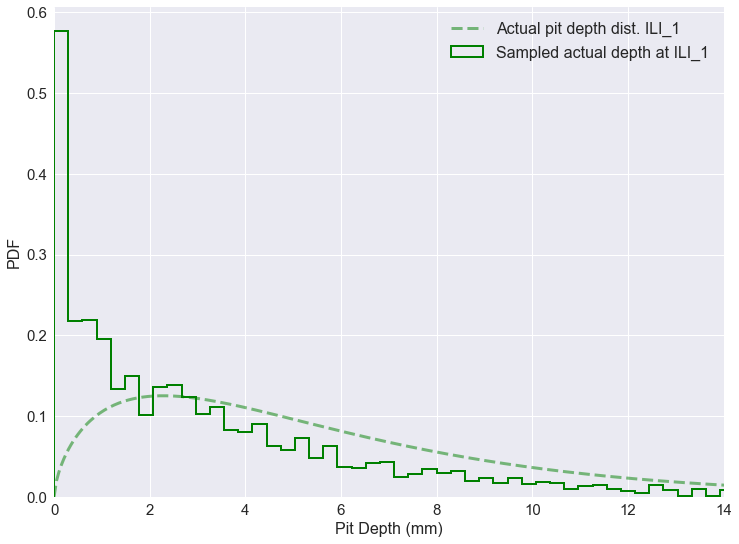

In [8]:
# Visual comparison of samples data and actual distribution
tt = np.linspace(t0, 50, 1000)
bins_no = 100
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth (mm)', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, gamma.pdf(tt, k*(ILI_info.ILI_time[0]-t0)**nu, scale = ScalePar), c='green', linestyle='--', alpha=0.5,\
         linewidth=3, label='Actual pit depth dist. ILI_1') 
plt.hist(Initiation_1_Actual_Depth[0], bins_no, color = 'green',  histtype='step', normed=True, linewidth=2,\
          label='Sampled actual depth at ILI_1');
pltEndPoint = 14
plt.xlim([0, pltEndPoint]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [9]:
# Generating synthetic actual and measured depth for those pits that are initiated between ILI 1 and ILI 2
np.random.seed(seed_number)
t2 = time_info (ILI_info.ILI_time[0], ILI_info.ILI_time[3])
Initiation_2_Actual_Depth = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[1]+1), columns = range(ILI_no-1))
POD_2 = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[1]+1), columns = range(1, ILI_no-1))
ILI_Index = 2
for i in range (1, ILI_info.Actual_Pit_No[ILI_Index-1]+1):
    for j in range(1, ILI_no):
        g = np.random.gamma(k*(ILI_info.ILI_time[j]-np.random.uniform(ILI_info.ILI_time[0], ILI_info.ILI_time[1]))**nu, scale = ScalePar) ;
        Initiation_2_Actual_Depth.loc[i, j-1] = g
        POD_2.loc[i, j] = 1 - np.exp(- Initiation_2_Actual_Depth.loc[i, j-1] / detection_threshold) 
        if POD_2.loc[i, j] > np.random.uniform():
            Measured_Depth.loc[i, j + 3] = a_ILI + b_ILI * Initiation_2_Actual_Depth.loc[i, j-1] \
            + np.random.normal (0, ILI_error_STD)
        else:
            Measured_Depth.loc[i, j + 3] = 'NaN'
        
p.line(ILI_info.ILI_time[0] + t2, k*(t2-t0)**nu*ScalePar , line_width = 2, legend ='Between ILI 1 & 2 : ' \
       + str (ILI_info.Actual_Pit_No[1]), color = 'yellow')

bokeh.models.renderers.GlyphRenderer(
    id='905abc04-4360-4213-9d59-d5b2e9b6fe16',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='f61af85a-46bd-428d-a85c-c670138f5736',
        callback=None,
        data={'x': {'__ndarray__': 'AAAAAAAAPkAAAAAAAAA/QAAAAAAAAEBAAAAAAACAQEAAAAAAAABBQAAAAAAAgEFAAAAAAAAAQkAAAAAAAIBCQAAAAAAAAENAAAAAAACAQ0AAAAAAAABEQAAAAAAAgERAAAAAAAAARUAAAAAAAIBFQAAAAAAAAEZAAAAAAACARkAAAAAAAABHQAAAAAAAgEdAAAAAAAAASEAAAAAAAIBIQAAAAAAAAElA',
          'shape': (21,),
          'dtype': 'float64'},
         'y': {'__ndarray__': 'AAAAAAAAAADhehSuR+HaP+aYr6VJ7+Y/jQuIrQJa7z+D2o0viZHzP/CQVn/5Pfc/CeEaaADA+j+gja03OiD+P8nF+klEsgBApjHD+5VIAkCTtMhxrNQDQH4nQAjHVwVAI3Pmx+TSBkCpxTeh1UYIQPn4XhFGtAlAjQTWRccbC0A4FLP21H0MQOohY7bZ2g1AyGvULzIzD0Db6yXRl0MQQMx+G+iM6xBA',
          'shape': (21,),
          'dtype': 'float64'}},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='db3a4092-3b95-4d19-9a03-db45f3755ab8',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='35b7bd08-5af9-48d8-ba39-131d708c3e9f',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.glyphs.Line(
        id='e2faa2b7-8627-4460-88b6-5b0e43cd12bc',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=1.0,
        line_cap='butt',
        line_color='yellow',
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph=bokeh.models.glyphs.Line(
        id='010bf849-23e6-4974-89dd-2bc731c2f1aa',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=0.1,
        line_cap='butt',
        line_color='#1f77b4',
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    selection_glyph=None,
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='8ce8c416-15b4-4290-95bc-220274d5f095',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='f61af85a-46bd-428d-a85c-c670138f5736',
            callback=None,
            data={'x': {'__ndarray__': 'AAAAAAAAPkAAAAAAAAA/QAAAAAAAAEBAAAAAAACAQEAAAAAAAABBQAAAAAAAgEFAAAAAAAAAQkAAAAAAAIBCQAAAAAAAAENAAAAAAACAQ0AAAAAAAABEQAAAAAAAgERAAAAAAAAARUAAAAAAAIBFQAAAAAAAAEZAAAAAAACARkAAAAAAAABHQAAAAAAAgEdAAAAAAAAASEAAAAAAAIBIQAAAAAAAAElA',
              'shape': (21,),
              'dtype': 'float64'},
             'y': {'__ndarray__': 'AAAAAAAAAADhehSuR+HaP+aYr6VJ7+Y/jQuIrQJa7z+D2o0viZHzP/CQVn/5Pfc/CeEaaADA+j+gja03OiD+P8nF+klEsgBApjHD+5VIAkCTtMhxrNQDQH4nQAjHVwVAI3Pmx+TSBkCpxTeh1UYIQPn4XhFGtAlAjQTWRccbC0A4FLP21H0MQOohY7bZ2g1AyGvULzIzD0Db6yXRl0MQQMx+G+iM6xBA',
              'shape': (21,),
              'dtype': 'float64'}},
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            selected=bokeh.models.selections.Selection(
                id='db3a4092-3b95-4d19-9a03-db45f3755ab8',
                indices=[],
                js_event_callbacks={},
     

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


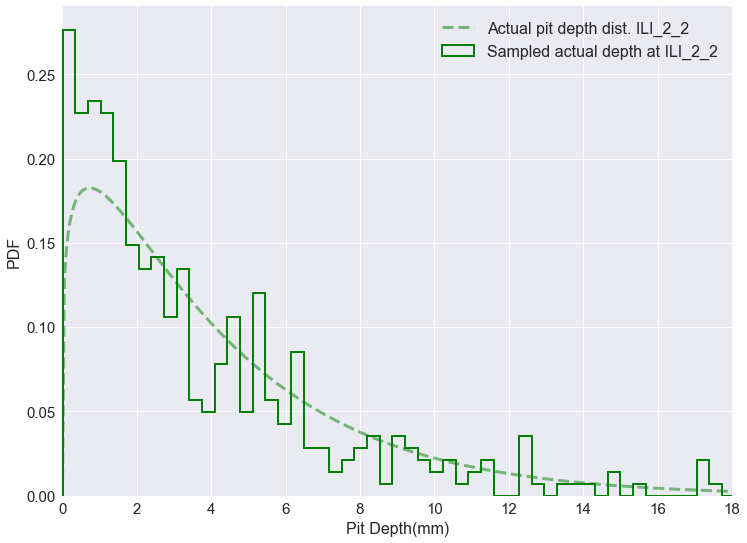

In [10]:
# Visual comparison of samples data and actual distribution
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth(mm)', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, gamma.pdf(tt, k*(ILI_info.ILI_time[3]-ILI_info.ILI_time[0])**nu, scale = ScalePar), c='green', linestyle='--', alpha=0.5,  linewidth=3,\
         label='Actual pit depth dist. ILI_2_2') 
plt.hist(Initiation_2_Actual_Depth[2], bins_no, color = 'green',  histtype='step', normed=True, linewidth=2,\
         label='Sampled actual depth at ILI_2_2');

plt.xlim([0, 18]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [11]:
# Generating synthetic actual and measured depth for those pits that are initiated between ILI 2 and ILI 3
np.random.seed(seed_number)
t3 = time_info (ILI_info.ILI_time[1], ILI_info.ILI_time[3])
Initiation_3_Actual_Depth = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[2]+1), columns = range(1, ILI_no-2))
POD_3 = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[2]+1), columns = range(1, ILI_no-2))
ILI_Index = 3
for i in tqdm(range(1, ILI_info.Actual_Pit_No[ILI_Index-1]+1)):
    for j in range (2, ILI_no):
        g = np.random.gamma(k*(ILI_info.ILI_time[j]-np.random.uniform(ILI_info.ILI_time[1], ILI_info.ILI_time[2]))**nu, scale = ScalePar) ;
        Initiation_3_Actual_Depth.loc[i, j-2] = g
        POD_3.loc[i, j] = 1 - np.exp(- Initiation_3_Actual_Depth.loc[i, j-2] / detection_threshold) 
        if POD_3.loc[i, j] > np.random.uniform():
            Measured_Depth.loc[i, j + 5] = a_ILI + b_ILI * Initiation_3_Actual_Depth.loc[i, j-2] \
            + np.random.normal (0, ILI_error_STD)
        else:
            Measured_Depth.loc[i, j + 5] = 'NaN'                
p.line(ILI_info.ILI_time[1] + t3, k*(t3-t0)**nu*ScalePar , line_width = 2, legend ='Between ILI 2 & 3 : ' \
       + str (ILI_info.Actual_Pit_No[2]), color = 'yellow')

bokeh.models.renderers.GlyphRenderer(
    id='c3908298-a0d4-4adf-ae57-d0effae3673f',
    data_source=bokeh.models.sources.ColumnDataSource(
        id='41d99392-2d9d-4a34-ac43-3ffd4e18150b',
        callback=None,
        data={'x': {'__ndarray__': 'AAAAAACAQUAAAAAAAABCQAAAAAAAgEJAAAAAAAAAQ0AAAAAAAIBDQAAAAAAAAERAAAAAAACAREAAAAAAAABFQAAAAAAAgEVAAAAAAAAARkAAAAAAAIBGQAAAAAAAAEdAAAAAAACAR0AAAAAAAABIQAAAAAAAgEhAAAAAAAAASUA=',
          'shape': (16,),
          'dtype': 'float64'},
         'y': {'__ndarray__': 'AAAAAAAAAADhehSuR+HaP+aYr6VJ7+Y/jQuIrQJa7z+D2o0viZHzP/CQVn/5Pfc/CeEaaADA+j+gja03OiD+P8nF+klEsgBApjHD+5VIAkCTtMhxrNQDQH4nQAjHVwVAI3Pmx+TSBkCpxTeh1UYIQPn4XhFGtAlAjQTWRccbC0A=',
          'shape': (16,),
          'dtype': 'float64'}},
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        selected=bokeh.models.selections.Selection(
            id='d292d60a-90e7-40f0-bfba-5a7a90871d2b',
            indices=[],
            js_event_callbacks={},
            js_property_callbacks={},
            line_indices=[],
            multiline_indices={},
            name=None,
            subscribed_events=[],
            tags=[]),
        selection_policy=bokeh.models.selections.UnionRenderers(
            id='44f45452-9052-4742-a527-b3356c4b07c6',
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            subscribed_events=[],
            tags=[]),
        subscribed_events=[],
        tags=[]),
    glyph=bokeh.models.glyphs.Line(
        id='6a237b71-7776-4fb3-8050-c258b1954619',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=1.0,
        line_cap='butt',
        line_color='yellow',
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    hover_glyph=None,
    js_event_callbacks={},
    js_property_callbacks={},
    level='glyph',
    muted=False,
    muted_glyph=None,
    name=None,
    nonselection_glyph=bokeh.models.glyphs.Line(
        id='bc242043-3c7e-4e3d-8d6c-bb989db55319',
        js_event_callbacks={},
        js_property_callbacks={},
        line_alpha=0.1,
        line_cap='butt',
        line_color='#1f77b4',
        line_dash=[],
        line_dash_offset=0,
        line_join='miter',
        line_width=2,
        name=None,
        subscribed_events=[],
        tags=[],
        x={'field': 'x'},
        y={'field': 'y'}),
    selection_glyph=None,
    subscribed_events=[],
    tags=[],
    view=bokeh.models.sources.CDSView(
        id='ff2a267a-cc99-44d1-8b3e-ac821919885c',
        filters=[],
        js_event_callbacks={},
        js_property_callbacks={},
        name=None,
        source=bokeh.models.sources.ColumnDataSource(
            id='41d99392-2d9d-4a34-ac43-3ffd4e18150b',
            callback=None,
            data={'x': {'__ndarray__': 'AAAAAACAQUAAAAAAAABCQAAAAAAAgEJAAAAAAAAAQ0AAAAAAAIBDQAAAAAAAAERAAAAAAACAREAAAAAAAABFQAAAAAAAgEVAAAAAAAAARkAAAAAAAIBGQAAAAAAAAEdAAAAAAACAR0AAAAAAAABIQAAAAAAAgEhAAAAAAAAASUA=',
              'shape': (16,),
              'dtype': 'float64'},
             'y': {'__ndarray__': 'AAAAAAAAAADhehSuR+HaP+aYr6VJ7+Y/jQuIrQJa7z+D2o0viZHzP/CQVn/5Pfc/CeEaaADA+j+gja03OiD+P8nF+klEsgBApjHD+5VIAkCTtMhxrNQDQH4nQAjHVwVAI3Pmx+TSBkCpxTeh1UYIQPn4XhFGtAlAjQTWRccbC0A=',
              'shape': (16,),
              'dtype': 'float64'}},
            js_event_callbacks={},
            js_property_callbacks={},
            name=None,
            selected=bokeh.models.selections.Selection(
                id='d292d60a-90e7-40f0-bfba-5a7a90871d2b',
                indices=[],
                js_event_callbacks={},
                js_property_callbacks={},
                line_indices=[],
                multiline_indices={},
                name=None,
                subscribed_events=[],
                tags=[]),
         

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


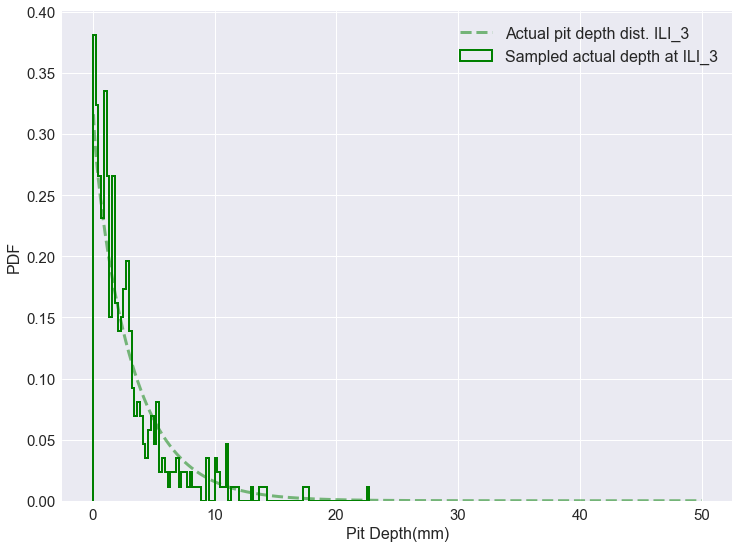

In [12]:
# Visual comparison of samples data and actual distribution

plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth(mm)', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, gamma.pdf(tt, k*(ILI_info.ILI_time[3]-ILI_info.ILI_time[1])**nu, scale = ScalePar), c='green', linestyle='--', alpha=0.5,  linewidth=3,\
         label='Actual pit depth dist. ILI_3') 
plt.hist(Initiation_3_Actual_Depth[1], bins_no, color = 'green',  histtype='step', normed=True, linewidth=2,\
         label='Sampled actual depth at ILI_3');

plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [13]:
# Generating synthetic actual and measured depth for those pits that are initiated between ILI 3 and prediction time
np.random.seed(seed_number)
t4 = time_info (ILI_info.ILI_time[2], ILI_info.ILI_time[3])
Prediction_Actual_Depth = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[3]+1), columns = range(ILI_no-3))
POD_4 = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[3]+1), columns = range(ILI_no-2))
ILI_Index = 4 # This is for prediction and it is not an ILI
for i in tqdm(range(1, ILI_info.Actual_Pit_No[ILI_Index-1]+1)):
    for j in range (3, ILI_no):
        g = np.random.gamma(k*(ILI_info.ILI_time[j]-np.random.uniform(ILI_info.ILI_time[2],ILI_info.ILI_time[3]))**nu, scale = ScalePar) ;           
        Prediction_Actual_Depth.loc[i, j-3] = g
        POD_4.loc[i, j] = 1 - np.exp(- Prediction_Actual_Depth.loc[i, j-3] / detection_threshold) 
        if POD_4.loc[i, j] > np.random.uniform():
            Measured_Depth.loc[i, j + 6] = a_ILI + b_ILI * Prediction_Actual_Depth.loc[i, j-3] \
                + np.random.normal (0, ILI_error_STD)
        else:
            Measured_Depth.loc[i, j + 6] = 'NaN'                
p.line(ILI_info.ILI_time[2] + t4, k*(t4-t0)**nu*ScalePar , line_width = 2, legend ='After ILI 3 : ' \
       + str (ILI_info.Actual_Pit_No[3]), color = 'yellow')
show(p) 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


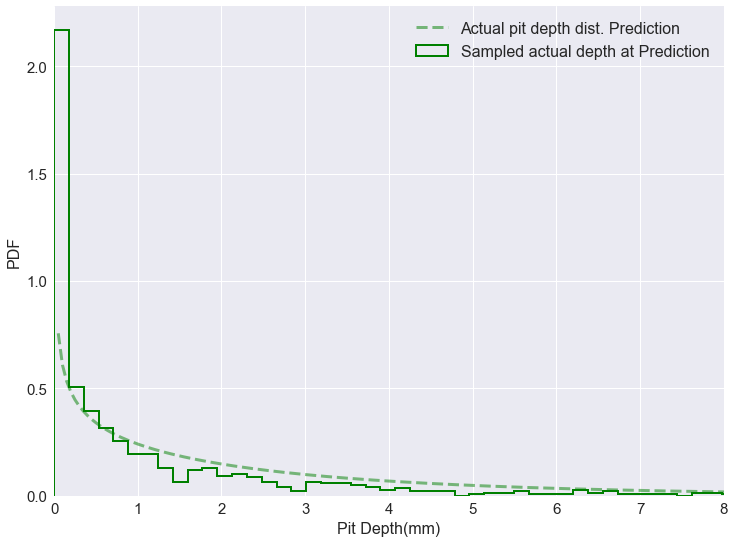

In [14]:
# Visual comparison of samples data and actual distribution

plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth(mm)', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, gamma.pdf(tt, k*(ILI_info.ILI_time[3]-ILI_info.ILI_time[2])**nu, scale = ScalePar), c='green', linestyle='--', alpha=0.5,  linewidth=3,\
         label='Actual pit depth dist. Prediction') 
plt.hist(Prediction_Actual_Depth[0], bins_no, color = 'green',  histtype='step', normed=True, linewidth=2,\
         label='Sampled actual depth at Prediction');
plt.xlim([0, 8]);

plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [15]:
# Remove the NaN values from measurements 
Cleaned_Measured_Depth_Simulated = pd.DataFrame(0, index = range(1, ILI_info.Actual_Pit_No[0]+1), columns = range(10)) 
No_Detected_Pits = pd.DataFrame(0, index = range(1, 2), columns = range(10))
for q in range(0,4):
    if q == 0: # Columns 0 to 3 of Measured_Depth are belong to those pits generated before ILI 1
        v = 0
        u = 4
    elif q == 1: # Columns 4 to 6 of Measured_Depth are belong to those pits generated beteween ILI 1 and 2
        v = 4
        u = 7
    elif q == 2: # Columns 7 to 8 of Measured_Depth are belong to those pits generated beteween ILI 2 and 3
        v = 7
        u = 9
    elif q == 3: # Column 9 of Measured_Depth are belong to those pits generated beteween ILI 3 and prediction time
        v = 9
        u = 10        
    for j in range (v, u):
        ii = 1
        for i in range(1, ILI_info.Actual_Pit_No[q]+1):
            if isinstance(Measured_Depth.loc[i,j], str) == False:                
                Cleaned_Measured_Depth_Simulated.loc[ii,j] = Measured_Depth.loc[i,j]
                No_Detected_Pits.loc[1, j] = No_Detected_Pits.loc[1, j] + 1
                ii = ii + 1

In [16]:
Cleaned_Measured_Depth_Simulated.columns = ['Y_1_1', 'Y_2_1', 'Y_3_1', 'Y_4_1', 'Y_2_2', 'Y_3_2', 'Y_4_2',\
                                 'Y_3_3', 'Y_3_4', 'Y_4_4']

In [17]:
Cleaned_Measured_Depth_Simulated.head()

,Y_1_1,Y_2_1,Y_3_1,Y_4_1,Y_2_2,Y_3_2,Y_4_2,Y_3_3,Y_3_4,Y_4_4
1,5.676005,5.577629,10.537661,9.461769,4.997012,3.923730,6.250469,13.623919,5.091853,3.617931
2,4.681896,2.262933,3.417344,9.323649,1.224459,4.270182,1.822653,2.052750,0.509748,14.221698
3,1.380496,8.227150,4.501145,10.301776,1.238998,1.708417,7.496557,1.608649,4.850915,1.255379
4,3.824912,11.056008,2.637742,3.254466,1.498888,2.424901,2.817507,1.374578,1.455661,2.143890
5,2.947647,4.028281,-0.159800,15.196352,1.707942,0.377103,4.709838,0.842359,3.324071,1.338329


In [18]:
# Save the generated synthetic data
Measured_Depth.to_csv('Measured_Depth.csv')
Initiation_1_Actual_Depth.to_csv('Initiation_1_Actual_Depth.csv')
Initiation_2_Actual_Depth.to_csv('Initiation_2_Actual_Depth.csv')
Initiation_3_Actual_Depth.to_csv('Initiation_3_Actual_Depth.csv')
Prediction_Actual_Depth.to_csv('Prediction_Actual_Depth.csv')
Cleaned_Measured_Depth_Simulated.to_csv('Cleaned_Measured_Depth_Simulated.csv')

In [19]:
m_1 = No_Detected_Pits[0] # Number of detected pits at ILI 1
m_2 = No_Detected_Pits[1] + No_Detected_Pits[4] # Number of detected pits at ILI 2
m_3 = No_Detected_Pits[2] + No_Detected_Pits[5] + No_Detected_Pits[7] # Number of detected pits at ILI 3
m_4 = No_Detected_Pits[3] + No_Detected_Pits[6] + No_Detected_Pits[8] + No_Detected_Pits[9] # Number of detected pits at prediction time

# 2-1-Add POFC

In this section false call error is added to consider POFC in synthetic data generation.

# 2-1-1 ILI_1

In [20]:
# Number of true calls at each ILI
No_TrueCalled_Pits = pd.DataFrame(0, index = range(1, 2), columns = range(3))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


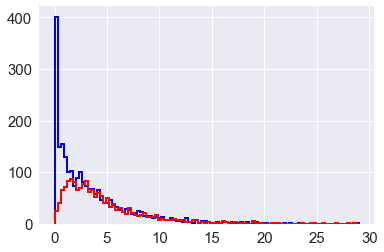

In [21]:
# Comparing the PMF of the actual depth of existing pits and the PMF of measurements of detected pits at ILI_1
frequency_info_1 = pd.DataFrame(0, index = range(1, bins_no+1), columns = range(6)).astype(float)
frequency_info_1.columns = ['actual_N','detected_N', 'reported_N', 'estimated_N_WO_POD', 'estimated_N_W_POD',\
                            'rounded_estimated_N_W_POD']
bins_start_1 = np.int(np.min(Initiation_1_Actual_Depth[0]))
bins_end_1   = np.int(np.max(Initiation_1_Actual_Depth[0]))
# find the bins intervals and the bins frequencies
(actual_N_1, bins_1, patches) = plt.hist(Initiation_1_Actual_Depth[0], bins_no,\
                                     range=(bins_start_1, bins_end_1),\
                                     histtype='step', normed=False, linewidth=2, color = 'blue',\
                                     label='Distribution of actual samples ILI_1_1');
# find the bins intervals and the bins frequencies
(detected_N, bins_1, patches1) = plt.hist(Cleaned_Measured_Depth_Simulated.Y_1_1[1:1642], bins_no,\
                                          range=(bins_start_1, bins_end_1),\
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_1.actual_N = actual_N_1
frequency_info_1.detected_N = detected_N

In [22]:
# Estimate the number of reported pits given synthetic detected pits 
for i in range (1, bins_no+1):
    POFC = np.exp(-(bins_1[i-1]+bins_1[i])/2/credible_pit_depth_threshold)  
    frequency_info_1.reported_N[i] = frequency_info_1.detected_N[i]/(1-POFC)

In [23]:
# find the distribution of R_1_1
np.random.seed(seed_number)
R_1_1 = pd.DataFrame(0, index = range(0, np.int(np.sum(frequency_info_1.reported_N))), columns = range(1)).astype(float) 
# Part of R_1_1 is equal to the truly detected pits
for i in range(0, np.int(m_1)):
    R_1_1[0][i] = Cleaned_Measured_Depth_Simulated.Y_1_1[i+1]
jj = 0
# for those bins that frequency of reported pits is higher than the detected pits, generate random number between lower and 
# upper bound of that bin
for i in range(1, bins_no+1):      
    if frequency_info_1.reported_N[i] > frequency_info_1.detected_N[i]:        
        for j in range(1, np.int(frequency_info_1.reported_N[i] - frequency_info_1.detected_N[i])+1):          
            R = np.random.uniform(bins_1[i-1], bins_1[i])
            R_1_1[0][np.int(m_1) + jj] = R
            jj = jj + 1     
R_1_1.to_csv('R_1_1.csv')

In [24]:
np.random.seed(seed_number)
# Fliter true calls measurements from reported measurements
Cleaned_Measured_Depth = pd.DataFrame(0, index = range(0, 5000), columns = range(4)).astype(float) 
Cleaned_Measured_Depth.columns = ['Y_1', 'Y_2', 'Y_3', 'Y_4']
No_TrueCalled_Pits[0][1] = 0
for item in R_1_1[0]:           
    if np.random.uniform(0,1) > np.exp(-item/credible_pit_depth_threshold):         
        Cleaned_Measured_Depth.Y_1[No_TrueCalled_Pits[0][1]] = item        
        No_TrueCalled_Pits[0][1] = No_TrueCalled_Pits[0][1] + 1

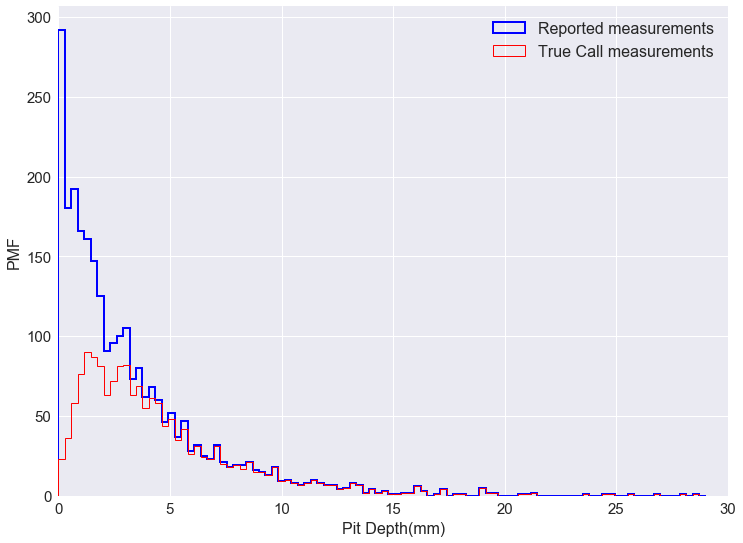

In [25]:
# Comapring histograms
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth(mm)', fontsize = 16)
plt.ylabel('PMF', fontsize = 16)
plt.hist(R_1_1[0], bins_no, color = 'blue', range=(bins_start_1, bins_end_1), histtype='step', density=False, linewidth=2,\
         label='Reported measurements');  
plt.hist(Cleaned_Measured_Depth.Y_1[0:No_TrueCalled_Pits[0][1]], bins_no, color = 'red', range=(bins_start_1, bins_end_1),\
         histtype='step', density=False, linewidth=1,\
         label='True Call measurements'); 
plt.xlim(bins_start_1, 30);

plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

# 2-1-1 ILI_2

In [26]:
# Y_2_d is the Cleaned simulated measured depth at ILI_2
Y_2_d = pd.DataFrame(pd.concat([Cleaned_Measured_Depth_Simulated.Y_2_1[0:No_Detected_Pits.loc[1][1]],\
                                         Cleaned_Measured_Depth_Simulated.Y_2_2[0:No_Detected_Pits.loc[1][4]]], axis=0,\
                                        join='outer', ignore_index=True, keys=None, levels=None, names=None,\
                                        verify_integrity=False, copy=True))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


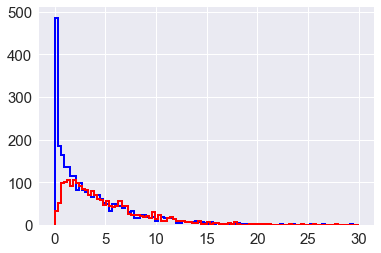

In [27]:
# Comparing the histograms and finding the bins intervals and frequencies
frequency_info_2 = pd.DataFrame(0, index = range(1, bins_no+1), columns = range(6)).astype(float)
frequency_info_2.columns = ['actual_N','detected_N', 'reported_N', 'estimated_N_WO_POD', 'estimated_N_W_POD',\
                            'rounded_estimated_N_W_POD']
bins_start_2 = np.int(np.min(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]])))
bins_end_2   = np.int(np.max(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]])))
(actual_N_2, bins_2, patches) = plt.hist(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]]), bins_no,\
                                     range=(bins_start_2, bins_end_2),\
                                     histtype='step', normed=False, linewidth=2, color = 'blue',\
                                     label='Distribution of actual samples ILI_2')
(detected_N_2, bins_2, patches2) = plt.hist(Y_2_d[0], bins_no, range=(bins_start_2, bins_end_2),\
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');


frequency_info_2.detected_N = detected_N_2
frequency_info_2.actual_N = actual_N_2

In [28]:
# Estimate the number of reported pits given synthetic detected pits
for i in range (1, bins_no+1):
    POFC = np.exp(-(bins_2[i-1]+bins_2[i])/2/credible_pit_depth_threshold)  
    frequency_info_2.reported_N[i] = frequency_info_2.detected_N[i]/(1-POFC)

In [29]:
# estimate the actual depth of reported pits and find the distribution of R_2
np.random.seed(seed_number)
R_2 = pd.DataFrame(0, index = range(0, np.int(np.sum(frequency_info_2.reported_N))), columns = range(1)).astype(float) 
for i in range(0, np.int(m_2)):
    R_2[0][i] = Y_2_d[0][i]
# for those bins that frequency of reported pits is higher than the detected pits, generate random number between lower and 
# upper bound of that bin
jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_2.reported_N[i] > frequency_info_2.detected_N[i]:        
        for j in range(1, np.int(frequency_info_2.reported_N[i] - frequency_info_2.detected_N[i])+1):          
            R = np.random.uniform(bins_2[i-1], bins_2[i])
            R_2[0][np.int(m_2) + jj] = R
            jj = jj + 1     
R_2.to_csv('R_2.csv')

In [30]:
# Fliter true calls measurements from reported measurements
np.random.seed(seed_number)
# Filter false calls from reported data 
No_TrueCalled_Pits[1][1] = 0
for item in R_2[0]:           
    if np.random.uniform(0,1) > np.exp(-item/credible_pit_depth_threshold):
        Cleaned_Measured_Depth.Y_2[No_TrueCalled_Pits[1][1]] = item
        No_TrueCalled_Pits[1][1] = No_TrueCalled_Pits[1][1] + 1
print(No_TrueCalled_Pits[1][1])

2042


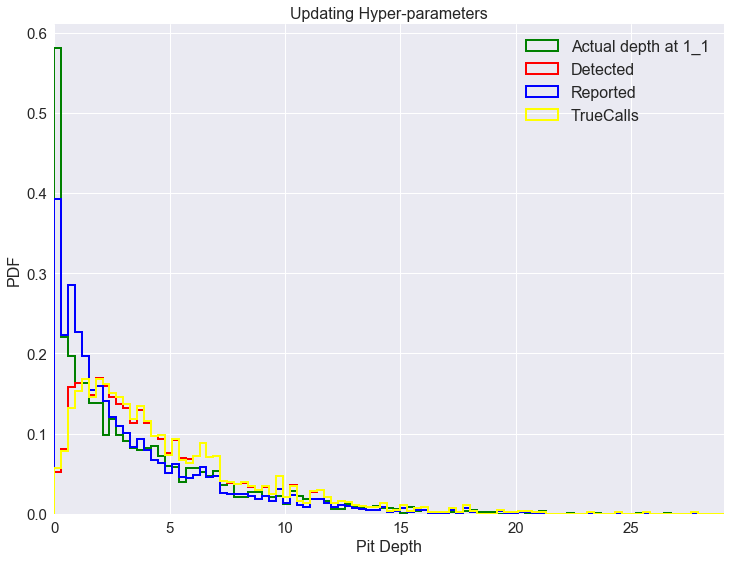

In [31]:
# Comparison
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)


dd = pd.DataFrame(pd.concat([Initiation_1_Actual_Depth[1], Initiation_2_Actual_Depth[0]], axis=0,\
                                        join='outer', ignore_index=True, keys=None, levels=None, names=None,\
                                        verify_integrity=False, copy=True))
plt.hist(dd[0], bins_no, color = 'green', range=(bins_start_2, bins_end_2),\
          histtype='step', density=True, linewidth=2, label='Actual depth at 1_1');
plt.hist(Y_2_d[0], bins_no, color = 'red', range=(bins_start_2, bins_end_2), histtype='step', density=True, linewidth=2,\
         label='Detected');  
plt.hist(R_2[0], bins_no, color = 'blue', range=(bins_start_2, bins_end_2), histtype='step', density=True, linewidth=2,\
         label='Reported');  
plt.hist(Cleaned_Measured_Depth.Y_2[0:No_TrueCalled_Pits[1][1]], bins_no, color = 'yellow', range=(bins_start_2, bins_end_2),\
         histtype='step', density=True, linewidth=2,\
         label='TrueCalls'); 
plt.xlim(bins_start_1, bins_end_1);

plt.title('Updating Hyper-parameters' , fontsize = 16)
plt.legend(loc='upper right');

# 2-1-2 ILI_3

In [32]:
# Y_3_d is the Cleaned simulated measured depth at ILI_3
Y_3_d = pd.DataFrame(pd.concat([Cleaned_Measured_Depth_Simulated.Y_3_1[0:No_Detected_Pits.loc[1][2]],\
                                Cleaned_Measured_Depth_Simulated.Y_3_2[0:No_Detected_Pits.loc[1][5]],\
                                Cleaned_Measured_Depth_Simulated.Y_3_3[0:No_Detected_Pits.loc[1][7]]], axis=0,\
                                        join='outer', ignore_index=True, keys=None, levels=None, names=None,\
                                        verify_integrity=False, copy=True))

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


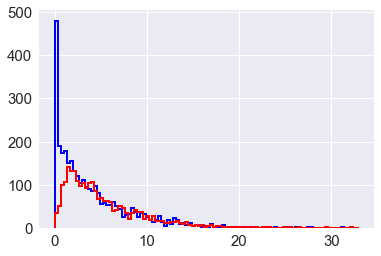

In [33]:
# Comparing the histograms and finding the bins intervals and frequencies
frequency_info_3 = pd.DataFrame(0, index = range(1, bins_no+1), columns = range(6)).astype(float)
frequency_info_3.columns = ['actual_N','detected_N', 'reported_N', 'estimated_N_WO_POD', 'estimated_N_W_POD',\
                            'rounded_estimated_N_W_POD']

bins_start_3 = np.int(np.min(pd.concat([Initiation_3_Actual_Depth[0],Initiation_2_Actual_Depth[1], Initiation_1_Actual_Depth[2]])))
bins_end_3   = np.int(np.max(pd.concat([Initiation_3_Actual_Depth[0],Initiation_2_Actual_Depth[1], Initiation_1_Actual_Depth[2]])))
(actual_N_3, bins_3, patches) = plt.hist(pd.concat([Initiation_3_Actual_Depth[0],Initiation_2_Actual_Depth[1], Initiation_1_Actual_Depth[2]]), bins_no,\
                                     range=(bins_start_3, bins_end_3),\
                                     histtype='step', normed=False, linewidth=2, color = 'blue',\
                                     label='Distribution of actual samples ILI_3')
(detected_N_3, bins_3, patches3) = plt.hist(Y_3_d[0], bins_no, range=(bins_start_3, bins_end_3),\
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');


frequency_info_3.detected_N = detected_N_3
frequency_info_3.actual_N = actual_N_3

In [34]:
# Estimate the number of reported pits given synthetic detected pits
for i in range (1, bins_no+1):
    POFC = np.exp(-(bins_3[i-1]+bins_3[i])/2/credible_pit_depth_threshold)  
    frequency_info_3.reported_N[i] = frequency_info_3.detected_N[i]/(1-POFC)

In [35]:
# estimate the actual depth of reported pits and find the distribution of R_3
np.random.seed(seed_number)
R_3 = pd.DataFrame(0, index = range(0, np.int(np.sum(frequency_info_3.reported_N))), columns = range(1)).astype(float) 
for i in range(0, np.int(m_3)):
    R_3[0][i] = Y_3_d[0][i]
jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_3.reported_N[i] > frequency_info_3.detected_N[i]:        
        for j in range(1, np.int(frequency_info_3.reported_N[i] - frequency_info_3.detected_N[i])+1):          
            R = np.random.uniform(bins_3[i-1], bins_3[i])
            R_3[0][np.int(m_3) + jj] = R
            jj = jj + 1     
R_3.to_csv('R_3.csv')

In [36]:
# Fliter true calls measurements from reported measurements
np.random.seed(seed_number)
No_TrueCalled_Pits[2][1] = 0
for item in R_3[0]:           
    if np.random.uniform(0,1) > np.exp(-item/credible_pit_depth_threshold):
        Cleaned_Measured_Depth.Y_3[No_TrueCalled_Pits[2][1]] = item
        No_TrueCalled_Pits[2][1] = No_TrueCalled_Pits[2][1] + 1
print(No_TrueCalled_Pits[2][1])

2359


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


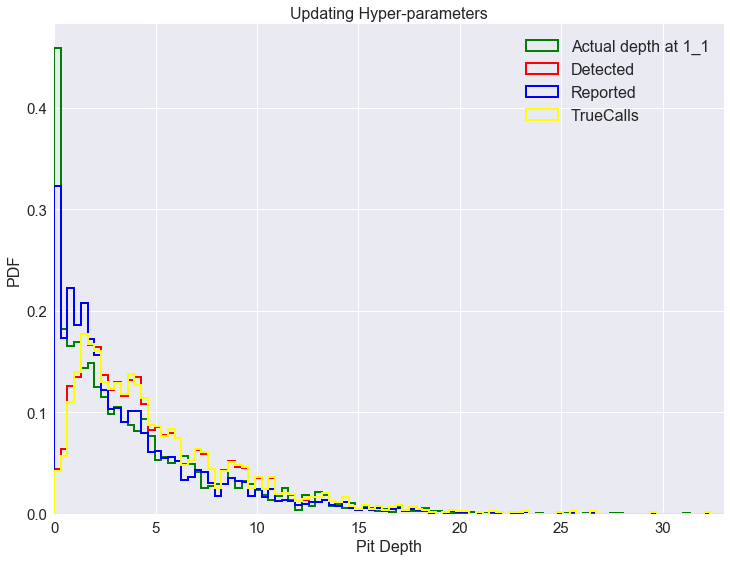

In [37]:
# Comparison
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)


ddd = pd.DataFrame(pd.concat([Initiation_1_Actual_Depth[2],\
                              Initiation_2_Actual_Depth[1],\
                              Initiation_3_Actual_Depth[0]],axis=0,\
                            join='outer', ignore_index=True, keys=None, levels=None, names=None,\
                             verify_integrity=False, copy=True))
plt.hist(ddd[0], bins_no, color = 'green', range=(bins_start_3, bins_end_3),\
          histtype='step', normed=True, linewidth=2, label='Actual depth at 1_1');
plt.hist(Y_3_d[0], bins_no, color = 'red', range=(bins_start_3, bins_end_3), histtype='step', normed=True, linewidth=2,\
         label='Detected');  
plt.hist(R_3[0], bins_no, color = 'blue', range=(bins_start_3, bins_end_3), histtype='step', normed=True, linewidth=2,\
         label='Reported');  
plt.hist(Cleaned_Measured_Depth.Y_3[0:No_TrueCalled_Pits[2][1]], bins_no, color = 'yellow', range=(bins_start_3, bins_end_3),\
         histtype='step', normed=True, linewidth=2,\
         label='TrueCalls'); 
plt.xlim(bins_start_3, bins_end_3);

plt.title('Updating Hyper-parameters' , fontsize = 16)
plt.legend(loc='upper right');

In [43]:
Cleaned_Measured_Depth.to_csv('Cleaned_Measured_Depth.csv')

In [39]:
No_TrueCalled_Pits

,0,1,2
1,1666,2042,2359


In [40]:
No_TrueCalled_Pits[2][1]

2359

# 3- Using ILI 1

# 3-1- Estimated D_1 , k , nu and Scale Par in Openbugs

In [41]:
# Use Cleaned_Measured_Depth.Y_1_1 as the first set of ILI data to estimate the hyper-parameters

In [42]:
alpha_1_1_actual = k*(ILI_info.ILI_time[0]-0)**nu
alpha_1_1_actual

1.652120550776528

In [44]:
# Estimated parameters at ILI_1 by OpenBUGS using true calls data at ILI_1
k_1  = 0.5102
nu_1 = 0.374
ScalePar_1 = 3.073
alpha_1_1_OpenBugs = 1.498
alpha_1_1_Est = k_1*(ILI_info.ILI_time[0]-0)**nu_1
alpha_1_1_Est

1.8204711613854778

In [45]:
# Estimated actual depth by OpenBUGS for detected pits at ILI 
D_1_1 = pd.read_excel('D.xlsx', sheetname='D_1_1')

# 3-2- Estimate the number of actual pits and their actual depth at  t_1

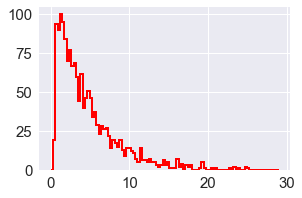

In [46]:
# Comparing the number of pits at each bin of the PMF of the actual depth and the estimated depth without POD


(estimated_N_WO_POD_1, bins_1, patches1) = plt.hist(D_1_1['depth'], bins_no, range=(bins_start_1, bins_end_1),\
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');


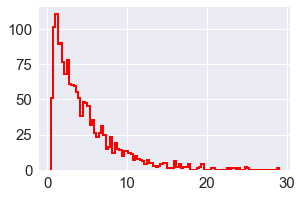

In [47]:

# Calculating number of pits at each bin of the PMF of the estimated depth without POD
(estimated_N_WO_POD_1, bins_1, patches1) = plt.hist(D_1_1['depth'], bins_no, \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_1.estimated_N_WO_POD = estimated_N_WO_POD_1

In [48]:
# Estimate the number of actual pits (M_1_1) given the number of truly detected pits (m_1) at ILI_1:
for i in range (1, bins_no+1):
    POD = 1-np.exp(-(bins_1[i-1]+bins_1[i])/2/detection_threshold)
    frequency_info_1.estimated_N_W_POD[i] = frequency_info_1.estimated_N_WO_POD[i]/POD
frequency_info_1.rounded_estimated_N_W_POD = np.round(frequency_info_1.estimated_N_W_POD, 0)

In [49]:
frequency_info_1.head()

,actual_N,detected_N,reported_N,estimated_N_WO_POD,estimated_N_W_POD,rounded_estimated_N_W_POD
1,461.0,23.0,278.465209,51.0,100.713768,101.0
2,159.0,39.0,171.139582,101.0,155.690291,156.0
3,133.0,78.0,222.753087,110.0,146.663240,147.0
4,137.0,59.0,130.220530,89.0,108.259039,108.0
5,103.0,100.0,185.290455,90.0,103.045486,103.0


In [50]:

p = figure(title = 'Comparison between actual and estimated number of pits at each bin', x_axis_label='actual_N',\
           y_axis_label='rounded_estimated_N_W_POD', plot_height = 700, plot_width = 700)   
p.scatter(actual_N_1, frequency_info_1.rounded_estimated_N_W_POD, line_width = 2, color = 'blue')
p.line([0, np.max(actual_N_1)], [0, np.max(actual_N_1)], line_width = 2, legend ='1 X 1 line', color = 'red')
p.legend.location = "top_left"
show(p) 

In [51]:
m_1_1 = np.int(np.sum(frequency_info_1.estimated_N_WO_POD))
m_1_1

1620

In [52]:
M_1_1= np.int(np.sum(frequency_info_1.rounded_estimated_N_W_POD))
M_1_1

1816

In [53]:
# estimate the actual depth of undetected pits and find the distribution of X_1
np.random.seed(seed_number)
X_1 = pd.DataFrame(0, index = range(0, M_1_1), columns = range(1)).astype(float) 
for i in range(0, m_1_1):
    X_1[0][i] = D_1_1['depth'][i]

jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_1.rounded_estimated_N_W_POD[i] > frequency_info_1.estimated_N_WO_POD[i]:        
        for j in range(1, np.int(frequency_info_1.rounded_estimated_N_W_POD[i] - frequency_info_1.estimated_N_WO_POD[i])+1):          
            X = np.random.uniform(bins_1[i-1], bins_1[i])
            X_1[0][m_1_1 + jj] = X
            jj = jj + 1     
X_1.to_csv('X_1.csv')

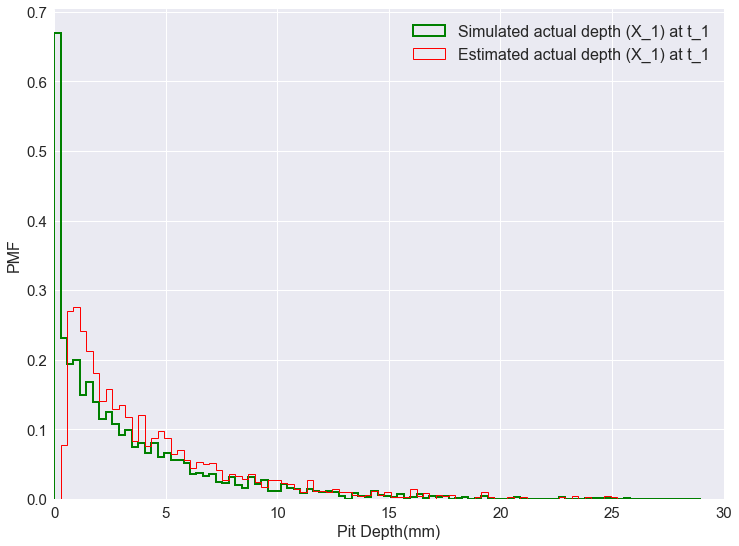

In [54]:
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth(mm)', fontsize = 16)
plt.ylabel('PMF', fontsize = 16)
bins_start_X_1 = np.int(np.min([np.min(Initiation_1_Actual_Depth[0]), np.min(X_1[0])]))
bins_end_X_1   = np.int(np.max([np.max(Initiation_1_Actual_Depth[0]), np.max(X_1[0])]))
plt.hist(Initiation_1_Actual_Depth[0], bins_no, color = 'green', range=(bins_start_X_1, bins_end_X_1),\
         histtype='step', normed=True, linewidth=2, label='Simulated actual depth (X_1) at t_1');
plt.hist(X_1[0], bins_no, color = 'red', range=(bins_start_X_1, bins_end_X_1), histtype='step', normed=True, linewidth=1,\
         label='Estimated actual depth (X_1) at t_1')  
plt.xlim(bins_start_X_1, 30)
plt.title('' , fontsize = 16)
plt.legend(loc='upper right')

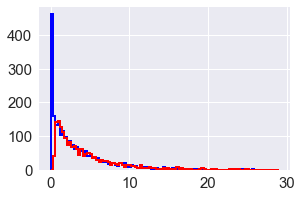

In [55]:
(actual_N_1, bins_1, patches) = plt.hist(Initiation_1_Actual_Depth[0], bins_no,\
                                     range=(bins_start_X_1, bins_end_X_1),\
                                     histtype='step', normed=False, linewidth=2, color = 'blue',\
                                     label='Distribution of actual samples ILI_1_1');
(estimated_N_W_POD_1, bins_1, patches1) = plt.hist(X_1[0], bins_no, range=(bins_start_X_1, bins_end_X_1),\
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');

In [56]:
def KL_divergences(h1_bin_freq, h2_bin_freq, bins):
    D_KL = 0
    for i in range(0, bins):
        if h2_bin_freq[i] > 0 and h1_bin_freq[i] > 0:
            D_KL += h1_bin_freq[i]*np.log(h1_bin_freq[i]/h2_bin_freq[i])
    return D_KL

In [57]:
N_Actual_1 = pd.concat([Initiation_1_Actual_Depth[0]]).shape[0]
N_Estimated_1 = X_1.shape[0] 
KLD1 = KL_divergences(actual_N_1/N_Actual_1, estimated_N_WO_POD_1/N_Estimated_1, bins_no)
KLD1

0.3467712039787846

In [58]:
SKLD1 = (KL_divergences(actual_N_1/N_Actual_1, estimated_N_WO_POD_1/N_Estimated_1, bins_no) + \
         KL_divergences(estimated_N_WO_POD_1/N_Estimated_1, actual_N_1/N_Actual_1, bins_no))/2
SKLD1

0.18663697147173708

In [59]:
ChiSq_1 = 0
for i in range(0, bins_no):
    if actual_N_1[i] > 0 or estimated_N_W_POD_1[i] > 0:
        ChiSq_1 = ChiSq_1 + (actual_N_1[i]/N_Actual_1 - estimated_N_W_POD_1[i]/N_Estimated_1)**2/\
        (actual_N_1[i]/N_Actual_1 + estimated_N_W_POD_1[i]/N_Estimated_1)
ChiSq_1

0.2769368019653389

# 4- Using ILI 2 

# 4-1- Cluster the ILI_2 measurement data 

In [60]:
# Estimated shape parameter at ILI 2 for pits that are initiated before ILI 1
alpha_prime_2_1 = k_1 * (ILI_info.ILI_time[1] - 0) ** nu_1
alpha_prime_2_1

1.9690098970016006

In [61]:
alpha_2_1_actual = k*(ILI_info.ILI_time[1]-0)**nu
alpha_2_1_actual

1.9420695337381417

In [62]:
alpha_2_2_actual = k*(ILI_info.ILI_time[1]-ILI_info.ILI_time[0])**nu
alpha_2_2_actual

0.5379622915790999

In [63]:
ScalePar

3.5

In [64]:
# Estimated shape parameter at ILI 2 for pits that are initiated between ILI 1 and 2
alpha_prime_2_2 = k_1 * (ILI_info.ILI_time[1] - ILI_info.ILI_time[0]) ** nu_1
alpha_prime_2_2

1.0563482598846923

In [65]:
detection_threshold

0.8410000000000001

In [66]:
𝑀_1_1

1816

In [67]:
ScalePar_1

3.073

In [68]:
# Using Wolfram Alpha to calculate m_prime_2_1
# WolframAlpha equation: 
# integrate 1816/gamma(1.969)/3.073^1.969*x^(1.969-1)*exp(-x/3.073)*(1-exp(-x/0.84))dx from x=0 to 20
m_prime_2_1 = 1708 # = 𝑀_1_1 ∫𝑔′_2_1(x)𝑃𝑂𝐷(𝑥)𝑑(𝑥)
m_prime_2_2 = m_2 - m_prime_2_1
m_prime_2_2

1    528
dtype: int64

In [69]:
np.random.seed(seed_number)
# Estimate the expected distribution of measuremnets at t_2
# For ILI_2_1
Y_prime_2_1 = pd.DataFrame(np.zeros(1))
D_prime_2_1 = np.random.gamma(alpha_prime_2_1, scale = ScalePar_1, size=m_prime_2_1) 

j = 0
for i in range (0, m_prime_2_1):
    Y_prime_2_1.loc[j] = a_ILI + b_ILI * D_prime_2_1[i] + np.random.normal (0, ILI_error_STD)  
    j = j + 1
mean_Y_prime_2_1 = np.mean(Y_prime_2_1)
STD_Y_prime_2_1  = np.std(Y_prime_2_1)

# For ILI_2_2
Y_prime_2_2 = pd.DataFrame(np.zeros(1))
D_prime_2_2 = np.random.gamma(alpha_prime_2_2, scale=ScalePar_1, size=m_prime_2_2[1]) 

j = 0
for i in range (0, m_prime_2_2[1]):
    Y_prime_2_2.loc[j] = a_ILI + b_ILI * D_prime_2_2[i] + np.random.normal (0, ILI_error_STD)  
    j = j + 1
mean_Y_prime_2_2 = np.mean(Y_prime_2_2)
STD_Y_prime_2_2 = np.std(Y_prime_2_2)

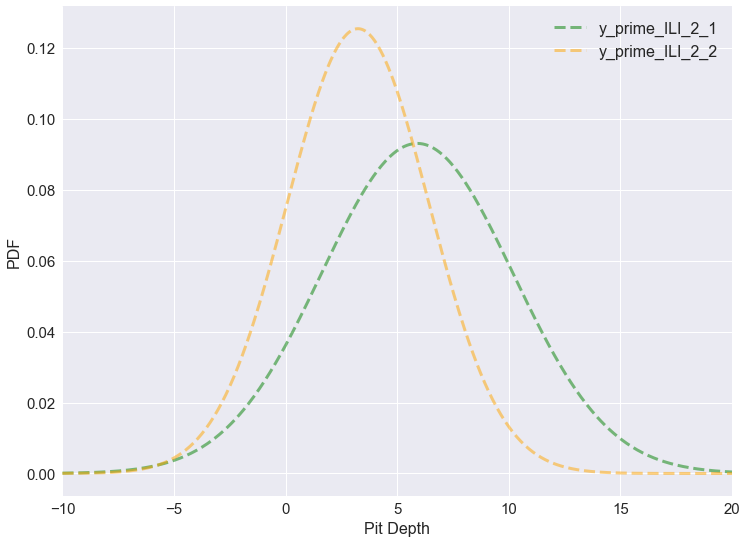

In [70]:
# Visualization of expected measured data at ILI_2
tt = np.linspace(-10, 50, 1000)
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, norm.pdf(tt, loc = mean_Y_prime_2_1, scale = STD_Y_prime_2_1), c='green', linestyle='--', alpha=0.5,  linewidth=3,\
         label='y_prime_ILI_2_1') 

plt.plot(tt, norm.pdf(tt, loc = mean_Y_prime_2_2, scale =  STD_Y_prime_2_2), c='Orange', linestyle='--', alpha=0.5,  linewidth=3,\
          label='y_prime_ILI_2_2')

plt.xlim([-10, 20]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [71]:
# Combine detected measurements at those pits that are detected at t_2 and initiated at 1st and 2nd intervals
Y_2_with_zeros = pd.DataFrame(Cleaned_Measured_Depth.Y_2)

In [72]:
# Remove zeros from Y_2_with_zeros and save them in an array
Y_2_array = pd.DataFrame(np.zeros(1))
j = 0
for i in range (0, Cleaned_Measured_Depth.Y_2.shape[0]):       
    if Y_2_with_zeros.Y_2[i] > 0 or Y_2_with_zeros.Y_2[i] < 0:
        Y_2_array.loc[j] = Y_2_with_zeros.Y_2[i] 
        j = j + 1


In [73]:
# Figureing out which detected pit at t_2 belongs to which population 2_1 or 2_2
Y_2 = pd.DataFrame(0, index = range(0, len(Y_2_array)), columns = range(6)).astype(float) 
Y_2.columns = ['measurement', 'Pr_yi_given_2_1', 'Pr_yi_given_2_2','Pr_2_1_given_yi', 'Pr_2_2_given_yi',\
               'cluster_index']
Y_2.measurement = Y_2_array

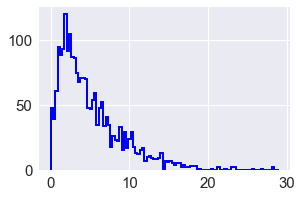

In [74]:
# Finding the start and end points of the bins of Y_2 which will be the same for Y_2_1 and Y_2_2 as well
measurement_bins_start_2 = np.int(np.min(Y_2.measurement))
measurement_bins_end_2   = np.int(np.max(Y_2.measurement))
(measurement_N_2, measurement_bins_2, patches) = plt.hist(Y_2.measurement, bins_no,\
                                     range=(measurement_bins_start_2, measurement_bins_end_2),\
                                     histtype='step', normed=False, linewidth=2, color = 'blue',\
                                     label='');


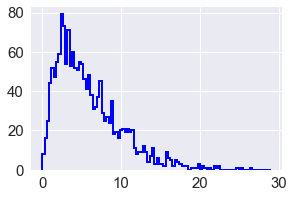

In [75]:
# Finding the frequency of each bin for Y_prime_2_1 using the same start and end bin as Y_2
(Y_prime_2_1_N, measurement_bins_2, patches) = plt.hist(Y_prime_2_1[0], bins_no,\
                                     range=(measurement_bins_start_2, measurement_bins_end_2),\
                                     histtype='step', normed=False, linewidth=2, color = 'blue',\
                                     label='Y_prime_2_1');


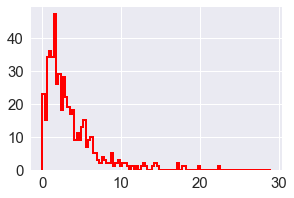

In [76]:
# Finding the frequency of each bin for Y_prime_2_1 using the same start and end bin as Y_2
(Y_prime_2_2_N, measurement_bins_2, patches) = plt.hist(Y_prime_2_2[0], bins_no,\
                                     range=(measurement_bins_start_2, measurement_bins_end_2),\
                                     histtype='step', normed=False, linewidth=2, color = 'red',\
                                     label='Y_prime_2_2');


In [77]:
# Figureing out which detected pit at t_2 belongs to which population 2_1 or 2_2 
Y_2_1_bins_freq = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 
Y_2_2_bins_freq = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 

expected_bin_no_2_1 = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 
expected_bin_no_2_2 = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 

bin_index_2 = pd.DataFrame(np.zeros(len(Y_2_array))).astype(int)

Y_prime_2_1_No = 0
Y_prime_2_2_No = 0


# identifying the bin index for each measured value
for i in range(0, len(Y_2_array)):    
    for j in range(0, bins_no):
        if Y_2.measurement[i] > measurement_bins_2[j] and Y_2.measurement[i] < measurement_bins_2[j+1]:
            bin_index_2.iloc[i] = np.int(j)
            break    

for i in range(0, len(Y_2_array)):     
    if Y_2_1_bins_freq[0][bin_index_2[0][i]] < Y_prime_2_1_N[bin_index_2[0][i]]:            
            Y_2.cluster_index[i] = 1
            Y_2_1_bins_freq[0][bin_index_2[0][i]] = Y_2_1_bins_freq[0][bin_index_2[0][i]] + 1
            Y_prime_2_1_No = Y_prime_2_1_No + 1
    else:
        Y_2.cluster_index[i] = 2
        Y_2_2_bins_freq[0][bin_index_2[0][i]] = Y_2_2_bins_freq[0][bin_index_2[0][i]] + 1
        Y_prime_2_2_No = Y_prime_2_2_No + 1     

In [78]:
# Find the arrays of Y_2_1 and Y_2_2
Y_2_1 = pd.DataFrame(0, index = range(1, Y_prime_2_1_No+1), columns = range(1)).astype(float)
Y_2_2 = pd.DataFrame(0, index = range(1, Y_prime_2_2_No+1), columns = range(1)).astype(float)
j1 = 1
j2 = 1
for i in range (0, len(Y_2_array)): 
    if Y_2.cluster_index[i] == 1:
        Y_2_1[0][j1] = Y_2.measurement[i]  
        j1 = j1 + 1
    elif Y_2.cluster_index[i] == 2:
        Y_2_2[0][j2] = Y_2.measurement[i]  
        j2 = j2 + 1    

In [79]:
Y_2.to_csv('Y_2.csv')

In [80]:
Y_2_1.to_csv('Y_2_1.csv')
Y_2_2.to_csv('Y_2_2.csv')

# 4-2- Use the Clustered ILI_2 measurement data to update the hyper-parameters and estimate the actual depth of the detected pits in OpenBUGS

In [81]:
# Actual shape parameter at ILI 2 for pits that are initiated before ILI 1
alpha_2_1_actual = k * (ILI_info.ILI_time[1] - 0) ** nu
alpha_2_1_actual

1.9420695337381417

In [82]:
# Actual shape parameter at ILI 2 for pits that are initiated between ILI 1 and ILI 2
alpha_2_2_actual = k * (ILI_info.ILI_time[1] - ILI_info.ILI_time[0]) ** nu
alpha_2_2_actual

0.5379622915790999

In [83]:
# Estimated parameters at ILI 2 by OpenBUGS at t_2
k_2  = .1293
nu_2 = 0.7229
ScalePar_2 = 3.026
alpha_2_1_Est = 1.752
alpha_2_2_Est = 0.5262

In [84]:
# Estimated actual depth by OpenBUGS for detected pits at ILI 
D_2_1 = pd.read_excel('D.xlsx', sheetname='D_2_1')
D_2_2 = pd.read_excel('D.xlsx', sheetname='D_2_2')
D_2 = pd.read_excel('D.xlsx', sheetname='D_2')

In [85]:
p = figure(title = 'Comparison between actual and estimated number of pits at each bin', x_axis_label='actual_N',\
           y_axis_label='rounded_estimated_N_W_POD', plot_height = 700, plot_width = 700)   
p.line( tt, k*(tt-t0)**nu*ScalePar, line_width = 2, legend ='actual',  color = 'red')
p.line( tt, k_1*(tt-t0)**nu_1*ScalePar_1, line_width = 2, legend ='Estimated 1', color = 'blue')
p.line( tt, k_2*(tt-t0)**nu_2*ScalePar_2, line_width = 2, legend ='Estimated 2', color = 'green')

p.legend.location = "top_left"

show(p) 

# 4-3- Estimate the number of actual pits and their actual depth at  t_2

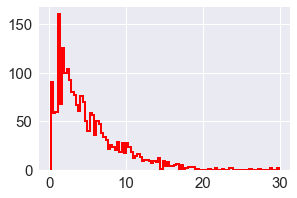

In [86]:
# Calculating number of pits at each bin of the PMF of actual depth and estimated depth without POD
(estimated_N_WO_POD_2, bins_2, patches2) = plt.hist(D_2['depth'], bins_no, \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_2.estimated_N_WO_POD = estimated_N_WO_POD_2

In [87]:
# Estimate the number of actual pits (M_2) given the number of truly detected pits (m_2) at ILI_2:
for i in range (1, bins_no+1):
    POD = 1-np.exp(-(bins_2[i-1]+bins_2[i])/2/detection_threshold)
    frequency_info_2.estimated_N_W_POD[i] = frequency_info_2.estimated_N_WO_POD[i]/POD
frequency_info_2.rounded_estimated_N_W_POD = np.round(frequency_info_2.estimated_N_W_POD, 0)

In [88]:
frequency_info_2.head()

,actual_N,detected_N,reported_N,estimated_N_WO_POD,estimated_N_W_POD,rounded_estimated_N_W_POD
1,471.0,46.0,539.155143,90.0,265.470853,265.0
2,204.0,60.0,255.602767,58.0,108.295529,108.0
3,155.0,77.0,214.037074,60.0,89.063640,89.0
4,153.0,92.0,198.130408,160.0,207.600096,208.0
5,135.0,92.0,166.713505,68.0,81.059083,81.0


In [89]:
m_2

1    2236
dtype: int64

In [90]:
# Estimated number of existing pits at t_2
M_2 = np.int(np.sum(frequency_info_2.rounded_estimated_N_W_POD))
M_2

2541

In [91]:
M_2-No_TrueCalled_Pits[1][1]

357

In [92]:
np.random.seed(seed_number)
# Find the PMF of X_2
X_2 = pd.DataFrame(0, index = range(0, M_2), columns = range(1)).astype(float) 
for i in range(0, No_TrueCalled_Pits[1][1]): # change this to m_2
    X_2[0][i] = D_2['depth'][i]
# estimate the actual depth of undetected pits and find the distribution of X_2

jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_2.rounded_estimated_N_W_POD[i] > frequency_info_2.estimated_N_WO_POD[i]:        
        for j in range(1, np.int(frequency_info_2.rounded_estimated_N_W_POD[i] - frequency_info_2.estimated_N_WO_POD[i])+1):          
            X = np.random.uniform(bins_2[i-1], bins_2[i])
            X_2[0][No_TrueCalled_Pits[1][1] + jj] = X # change this to m_2
            jj = jj + 1     
X_2.to_csv('X_2.csv')
print(jj)

357


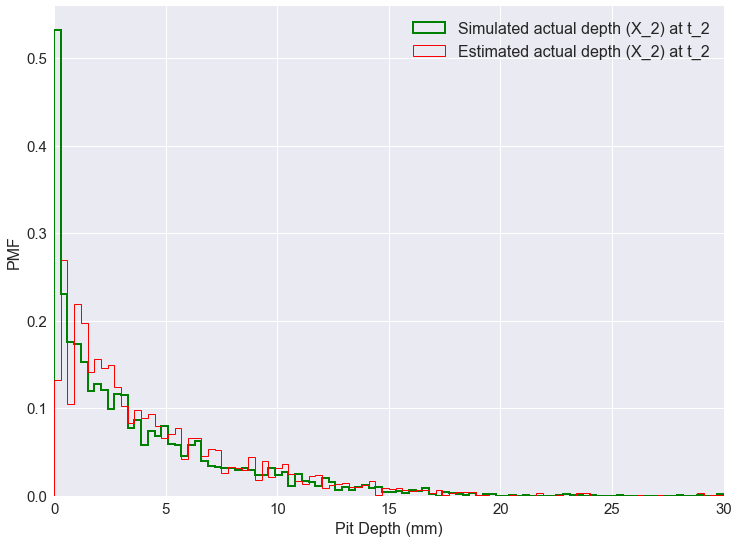

In [93]:
# Visual comparison between actual and estimated depth for X_2
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth (mm)', fontsize = 16)
plt.ylabel('PMF', fontsize = 16)
bins_start_X_2 = np.int(np.min([np.min(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]])),\
                              np.min(X_2[0])]))
bins_end_X_2   = np.int(np.max([np.max(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]])),\
                              np.max(X_2[0])]))
plt.hist(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]]), bins_no, color = 'green',\
         range=(bins_start_X_2, bins_end_X_2), histtype='step', density=True, linewidth=2,\
         label='Simulated actual depth (X_2) at t_2');
plt.hist(X_2[0], bins_no, color = 'red', range=(bins_start_X_2, bins_end_X_2), histtype='step', density=True,\
         linewidth=1, label='Estimated actual depth (X_2) at t_2');

plt.xlim([bins_start_X_2, 30]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

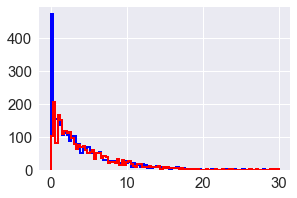

In [94]:
(actual_N_2, bins_2, patches) = plt.hist(pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]]),\
                                         bins_no, range=(bins_start_X_2, bins_end_X_2),\
                                     histtype='step', density=False, linewidth=2, color = 'blue',\
                                     label='Distribution of actual samples ILI_2');
(estimated_N_W_POD_2, bins_2, patches2) = plt.hist(X_2[0], bins_no, range=(bins_start_X_2, bins_end_X_2),\
                                                 histtype='step', density=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');

In [95]:
N_Actual_2 = pd.concat([Initiation_2_Actual_Depth[0], Initiation_1_Actual_Depth[1]]).shape[0]
N_Estimated_2 = X_2.shape[0] 
KLD2 = KL_divergences(actual_N_2/N_Actual_2, estimated_N_WO_POD_2/N_Estimated_2, bins_no)
KLD2

0.33370365692422577

In [96]:
SKLD2 = (KL_divergences(actual_N_2/N_Actual_2, estimated_N_WO_POD_2/N_Estimated_2, bins_no) + \
         KL_divergences(estimated_N_WO_POD_2/N_Estimated_2, actual_N_2/N_Actual_2, bins_no))/2
SKLD2

0.16278149769367364

In [97]:
ChiSq_2 = 0
for i in range(0, bins_no):
    if actual_N_2[i] > 0 or estimated_N_W_POD_2[i] > 0:
        ChiSq_2 = ChiSq_2 + (actual_N_2[i]/N_Actual_2 - estimated_N_W_POD_2[i]/N_Estimated_2)**2/\
        (actual_N_2[i]/N_Actual_2 + estimated_N_W_POD_2[i]/N_Estimated_2)
ChiSq_2

0.11933119809497322

# 5- Using ILI 3 data

# 5-1- Cluster the ILI_3 measurement data 

In [98]:
# Estimated shape parameter at ILI 3 for pits that are initiated before ILI 1
alpha_prime_3_1 = k_2 * (ILI_info.ILI_time[2] - 0) ** nu_2
alpha_prime_3_1

1.9277265859254706

In [99]:
alpha_3_1_actual = k * (ILI_info.ILI_time[2] - 0) ** nu
alpha_3_1_actual

2.141442654445383

In [100]:
# Estimated shape parameter at ILI 3 for pits that are initiated between ILI 1 and 2
alpha_prime_3_2 = k_2 * (ILI_info.ILI_time[2] - ILI_info.ILI_time[0]) ** nu_2
alpha_prime_3_2

0.7793609608356007

In [101]:
alpha_3_2_actual = k * (ILI_info.ILI_time[2] - ILI_info.ILI_time[0]) ** nu
alpha_3_2_actual

0.8151358363887973

In [102]:
# Estimated shape parameter at ILI 3 for pits that are initiated between ILI 2 and 3
alpha_prime_3_3 = k_2 * (ILI_info.ILI_time[2] - ILI_info.ILI_time[1]) ** nu_2
alpha_prime_3_3

0.41388905411294513

In [103]:
alpha_3_3_actual = k * (ILI_info.ILI_time[2] - ILI_info.ILI_time[1]) ** nu
alpha_3_3_actual

0.41503729068610185

In [104]:
𝑀_1_1

1816

In [105]:
M_2

2541

In [106]:
M_2-𝑀_1_1

725

In [107]:
m_3

1    2631
dtype: int64

In [108]:
ScalePar

3.5

In [109]:
ScalePar_2

3.026

In [110]:
# Using Wolfram Alpha to calculate m_prime_3_3
# = 𝑀_1_1 ∫𝑔′_3_1(x)𝑃𝑂𝐷(𝑥)𝑑(𝑥), 𝑔′_3_1(x) = gamma(alpha_prime_3_1, ScalePar_1) = 
# integrate 1816/gamma(1.927)/3.026^1.927*x^(1.927-1)*exp(-x/3.026)*(1-exp(-x/0.84))dx from x=0 to 20
m_prime_3_1 = 1704 
# integrate 725/gamma(0.779)/1.765^0.779*x^(0.779-1)*exp(-x/1.765)*(1-exp(-x/0.84))dx from x=0 to 20
m_prime_3_2 = 425 # = (M_2-𝑀_1_1) ∫𝑔′_3_2(x)𝑃𝑂𝐷(𝑥)𝑑(𝑥), 𝑔′_3_2(x) = gamma(alpha_prime_3_2, ScalePar_2)
m_prime_3_3 = m_3 - m_prime_3_1 - m_prime_3_2
m_prime_3_3

1    502
dtype: int64

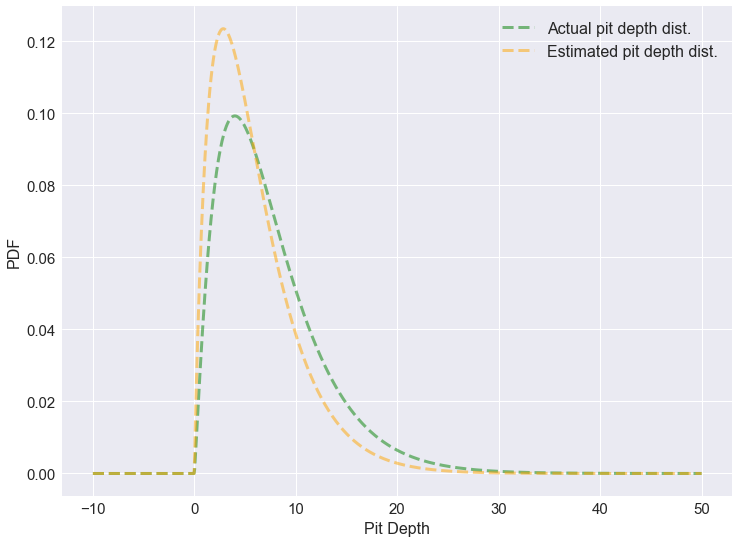

In [111]:
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, gamma.pdf(tt, alpha_3_1_actual, scale = ScalePar), c='green', linestyle='--', alpha=0.5,  linewidth=3,\
         label='Actual pit depth dist.') 

plt.plot(tt, gamma.pdf(tt, alpha_prime_3_1, scale = ScalePar_1), c='Orange', linestyle='--', alpha=0.5,  linewidth=3,\
          label='Estimated pit depth dist.')

plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [112]:
Y_3_with_zeros = pd.DataFrame(Cleaned_Measured_Depth.Y_3)

In [113]:
# Remove zeros from Y_3_with_zeros
Y_3_array = pd.DataFrame(np.zeros(1)).astype(float)
j = 0
for i in range (0, Cleaned_Measured_Depth.Y_3.shape[0]):       
    if Y_3_with_zeros.Y_3[i] > 0 or Y_3_with_zeros.Y_3[i] < 0:
        Y_3_array.loc[j] = Y_3_with_zeros.Y_3[i]  
        j = j + 1

In [114]:
# Store the ILI 3 cleaned data in one new file Y_3 for clustering
Y_3 = pd.DataFrame(0, index = range(0, len(Y_3_array)), columns = range(8)).astype(float) 
Y_3.columns = ['measurement', 'Pr_yi_given_3_1', 'Pr_yi_given_3_2','Pr_yi_given_3_3','Pr_3_1_given_yi',\
               'Pr_3_2_given_yi', 'Pr_3_3_given_yi', 'cluster_index']
Y_3.measurement = Y_3_array

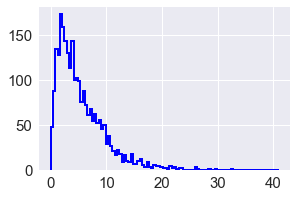

In [115]:
# Finding the start and end points of the bins of Y_3 which will be the same for Y_3_1, Y_3_2, and Y_3_3 as well
measurement_bins_start_3 = np.int(np.min(Y_3.measurement))
measurement_bins_end_3   = np.int(np.max(Y_3.measurement))
(measurement_N_3, measurement_bins_3, patches) = plt.hist(Y_3.measurement, bins_no,\
                                     range=(measurement_bins_start_3, measurement_bins_end_3),\
                                     histtype='step', density=False, linewidth=2, color = 'blue',\
                                     label='Y_3');


In [116]:
np.random.seed(seed_number)
# Estimate the expected distribution of measuremnets at t_3
# For ILI_3_1
Y_prime_3_1 = pd.DataFrame(np.zeros(1))
D_prime_3_1 = np.random.gamma(alpha_prime_3_1, scale = ScalePar_2, size = m_prime_3_1) 

j = 0
for i in range (0, np.int(m_prime_3_1)):
    Y_prime_3_1.loc[j] = a_ILI + b_ILI * D_prime_3_1[i] + np.random.normal (0, ILI_error_STD)  
    j = j + 1
mean_Y_prime_3_1 = np.mean(Y_prime_3_1)
STD_Y_prime_3_1 = np.std(Y_prime_3_1)

# For ILI_3_2
Y_prime_3_2 = pd.DataFrame(np.zeros(1))
D_prime_3_2 = np.random.gamma(alpha_prime_3_2, scale = ScalePar_2, size = m_prime_3_2) 

j = 0
for i in range (0, np.int(m_prime_3_2)):
    Y_prime_3_2.loc[j] = a_ILI + b_ILI * D_prime_3_2[i] + np.random.normal (0, ILI_error_STD)  
    j = j + 1
mean_Y_prime_3_2 = np.mean(Y_prime_3_2)
STD_Y_prime_3_2 = np.std(Y_prime_3_2)

# For ILI_3_3
Y_prime_3_3 = pd.DataFrame(np.zeros(1))
D_prime_3_3 = np.random.gamma(alpha_prime_3_3, scale = ScalePar_2, size = m_prime_3_3[1]) 

j = 0
for i in range (0, np.int(m_prime_3_3)):
    Y_prime_3_3.loc[j] = a_ILI + b_ILI * D_prime_3_3[i] + np.random.normal (0, ILI_error_STD)  
    j = j + 1
mean_Y_prime_3_3 = np.mean(Y_prime_3_3)
STD_Y_prime_3_3 = np.std(Y_prime_3_3)

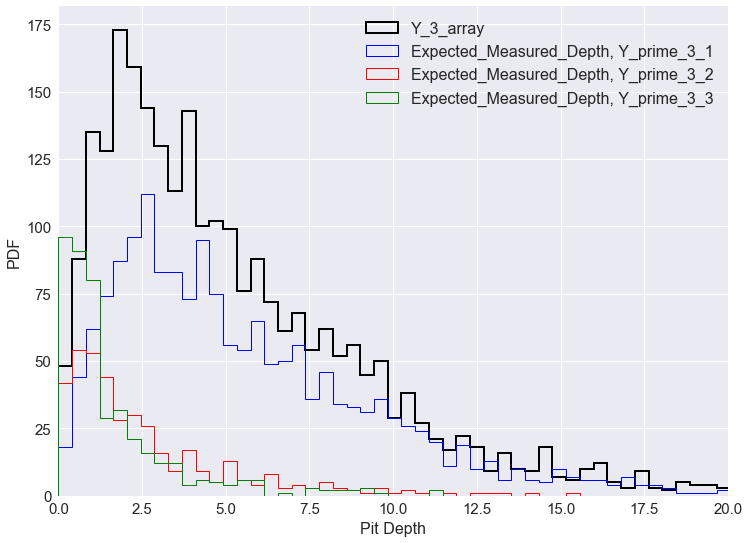

In [117]:
# Visual comparison between actual and clustered measurements
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)

plt.hist(Y_3_array[0], bins_no, color = 'black', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step',\
         density=False, linewidth=2,label='Y_3_array');

# plt.hist(Cleaned_Measured_Depth.Y_3_1[1:1443], bins_no, color = 'blue', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', normed=False, linewidth=2,\
#          label='Cleaned_Measured_Depth.Y_3_1');
# plt.hist(Cleaned_Measured_Depth.Y_3_2[1:269], bins_no, color = 'red', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', normed=False, linewidth=2,\
#          label='Cleaned_Measured_Depth.Y_3_2');
# plt.hist(Cleaned_Measured_Depth.Y_3_3[1:109], bins_no, color = 'green', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', normed=False, linewidth=2,\
#          label='Cleaned_Measured_Depth.Y_3_3');

plt.hist(Y_prime_3_1[0], bins_no, color = 'blue', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', density=False, linewidth=1,\
         label='Expected_Measured_Depth, Y_prime_3_1');
plt.hist(Y_prime_3_2[0], bins_no, color = 'red', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', density=False, linewidth=1,\
         label='Expected_Measured_Depth, Y_prime_3_2');
plt.hist(Y_prime_3_3[0], bins_no, color = 'green', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', density=False, linewidth=1,\
         label='Expected_Measured_Depth, Y_prime_3_3');

plt.xlim([measurement_bins_start_3, 20]);
plt.title('' , fontsize = measurement_bins_end_3)
plt.legend(loc='upper right');

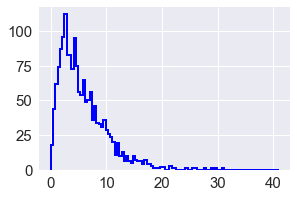

In [118]:
# Finding the frequency of each bin for Y_prime_3_1 using the same start and end bin as Y_3
(Y_prime_3_1_N, measurement_bins_3, patches) = plt.hist(Y_prime_3_1[0], bins_no,\
                                     range=(measurement_bins_start_3, measurement_bins_end_3),\
                                     histtype='step', density=False, linewidth=2, color = 'blue',\
                                     label='Y_prime_3_1');


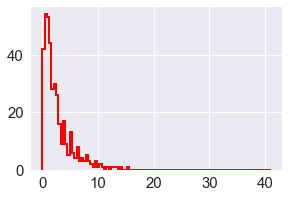

In [119]:
# Finding the frequency of each bin for Y_prime_3_2 using the same start and end bin as Y_3
(Y_prime_3_2_N, measurement_bins_3, patches) = plt.hist(Y_prime_3_2[0], bins_no,\
                                     range=(measurement_bins_start_3, measurement_bins_end_3),\
                                     histtype='step', density=False, linewidth=2, color = 'red',\
                                     label='Y_prime_3_2');


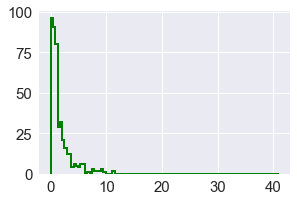

In [120]:
# Finding the frequency of each bin for Y_prime_3_3 using the same start and end bin as Y_3
(Y_prime_3_3_N, measurement_bins_3, patches) = plt.hist(Y_prime_3_3[0], bins_no,\
                                     range=(measurement_bins_start_3, measurement_bins_end_3),\
                                     histtype='step', density=False, linewidth=2, color = 'green',\
                                     label='Y_prime_3_3');


In [121]:
# Figureing out which detected pit at t_3 belongs to which population 3_1 or 3_2 or 3_3
Y_3_1_bins_freq = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 
Y_3_2_bins_freq = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 
Y_3_3_bins_freq = pd.DataFrame(0, index = range(0, bins_no), columns = range(1)).astype(int) 

bin_index_3 = pd.DataFrame(np.zeros(len(Y_3_array))).astype(int)

Y_prime_3_1_No = 0
Y_prime_3_2_No = 0
Y_prime_3_3_No = 0

# identifying the bin index for each measured value
for i in range(0, len(Y_3_array)):    
    for j in range(0, bins_no):
        if Y_3.measurement[i] > measurement_bins_3[j] and Y_3.measurement[i] < measurement_bins_3[j+1]:
            bin_index_3.iloc[i] = np.int(j)
            break     
    
for i in range(0, len(Y_3_array)):     
    if Y_3_1_bins_freq[0][bin_index_3[0][i]] < Y_prime_3_1_N[bin_index_3[0][i]]:            
            Y_3.cluster_index[i] = 1
            Y_3_1_bins_freq[0][bin_index_3[0][i]] = Y_3_1_bins_freq[0][bin_index_3[0][i]] + 1
            Y_prime_3_1_No = Y_prime_3_1_No + 1
    elif Y_3_2_bins_freq[0][bin_index_3[0][i]] < Y_prime_3_2_N[bin_index_3[0][i]]:            
        Y_3.cluster_index[i] = 2
        Y_3_2_bins_freq[0][bin_index_3[0][i]] = Y_3_2_bins_freq[0][bin_index_3[0][i]] + 1
        Y_prime_3_2_No = Y_prime_3_2_No + 1 
    else:
        Y_3.cluster_index[i] = 3
        Y_3_3_bins_freq[0][bin_index_3[0][i]] = Y_3_3_bins_freq[0][bin_index_3[0][i]] + 1
        Y_prime_3_3_No = Y_prime_3_3_No + 1 
    

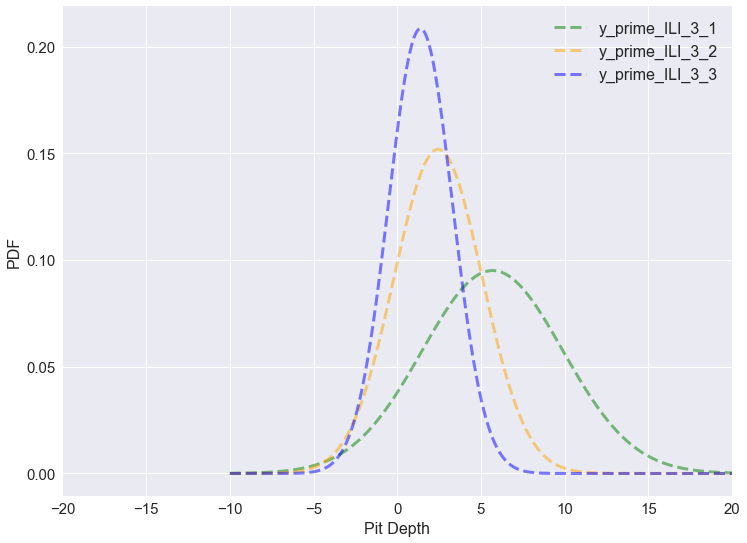

In [122]:
# Visualization of PDF of expected measured data at ILI_3
tt = np.linspace(-10, 50, 1000)
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
plt.plot(tt, norm.pdf(tt, mean_Y_prime_3_1, STD_Y_prime_3_1), c='green', linestyle='--', alpha=0.5,  linewidth=3,\
         label='y_prime_ILI_3_1') 
plt.plot(tt, norm.pdf(tt, mean_Y_prime_3_2, STD_Y_prime_3_2), c='orange', linestyle='--', alpha=0.5,  linewidth=3,\
          label='y_prime_ILI_3_2')
plt.plot(tt, norm.pdf(tt, mean_Y_prime_3_3, STD_Y_prime_3_3), c='blue', linestyle='--', alpha=0.5,  linewidth=3,\
          label='y_prime_ILI_3_3')
plt.xlim([-20, 20]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

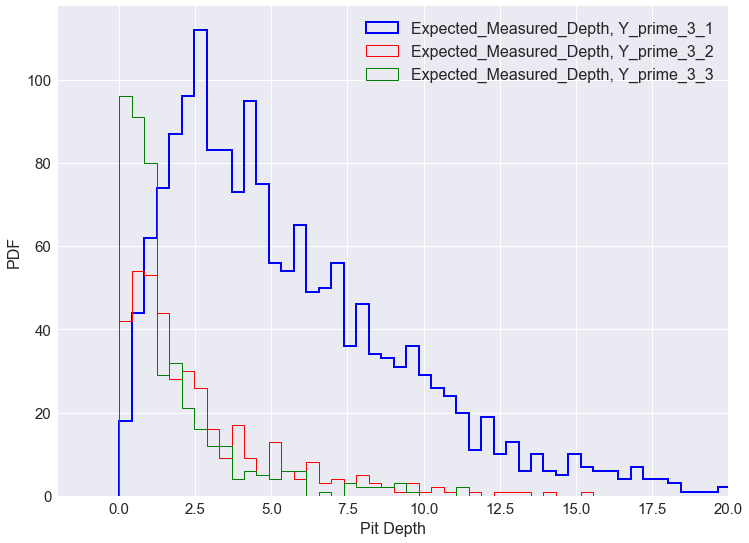

In [123]:
# Visualization of PMF of expected measured data at ILI_3
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)
# Change these bins start and end to 3
plt.hist(Y_prime_3_1[0], bins_no, color = 'blue', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', density=False, linewidth=2,\
         label='Expected_Measured_Depth, Y_prime_3_1');
plt.hist(Y_prime_3_2[0], bins_no, color = 'red', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', density=False, linewidth=1,\
         label='Expected_Measured_Depth, Y_prime_3_2');
plt.hist(Y_prime_3_3[0], bins_no, color = 'green', range=(measurement_bins_start_3, measurement_bins_end_3), histtype='step', density=False, linewidth=1,\
         label='Expected_Measured_Depth, Y_prime_3_3');

plt.xlim([-2, 20]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [124]:
Y_3.to_csv('Y_3.csv')

In [125]:
# Find the arrays of Y_3_1 and Y_3_2 and Y_3_3
Y_3_1 = pd.DataFrame(0, index = range(1, Y_prime_3_1_No+1), columns = range(1)).astype(float)
Y_3_2 = pd.DataFrame(0, index = range(1, Y_prime_3_2_No+1), columns = range(1)).astype(float)
Y_3_3 = pd.DataFrame(0, index = range(1, Y_prime_3_3_No+1), columns = range(1)).astype(float)
j1 = 1
j2 = 1
j3 = 1
for i in range (0, len(Y_3_array)): 
    if Y_3.cluster_index[i] == 1:
        Y_3_1.loc[j1][0] = Y_3.measurement[i]  
        j1 = j1 + 1
    elif Y_3.cluster_index[i] == 2:
        Y_3_2.loc[j2][0] = Y_3.measurement[i]  
        j2 = j2 + 1
    elif Y_3.cluster_index[i] == 3:
        Y_3_3.loc[j3][0] = Y_3.measurement[i]  
        j3 = j3 + 1

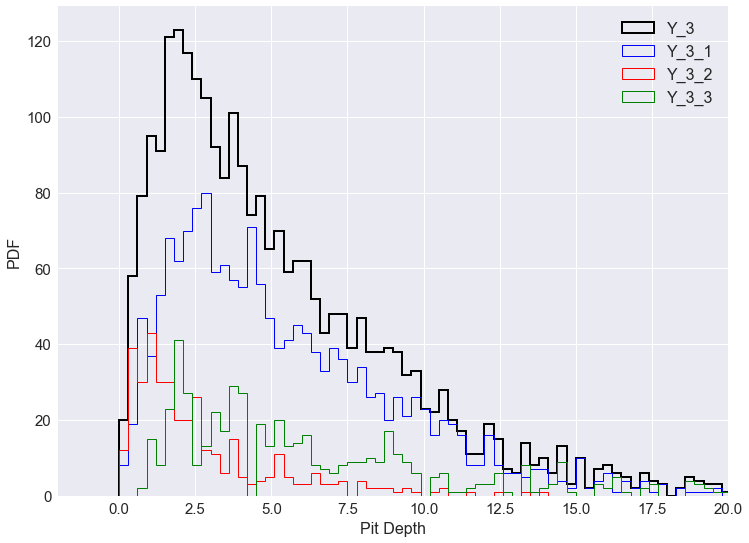

In [126]:
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth', fontsize = 16)
plt.ylabel('PDF', fontsize = 16)


plt.hist(Y_3.measurement, bins_no, color = 'black', range=(bins_start_2, bins_end_2), histtype='step', normed=False, linewidth=2,\
         label='Y_3');
plt.hist(Y_3_1[0], bins_no, color = 'blue', range=(bins_start_2, bins_end_2), histtype='step', normed=False, linewidth=1,\
         label='Y_3_1');
plt.hist(Y_3_2[0], bins_no, color = 'red', range=(bins_start_2, bins_end_2), histtype='step', normed=False, linewidth=1,\
         label='Y_3_2');
plt.hist(Y_3_3[0], bins_no, color = 'green', range=(bins_start_2, bins_end_2), histtype='step', normed=False, linewidth=1,\
         label='Y_3_3');


plt.xlim([-2, 20]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

In [127]:
Y_3_1.to_csv('Y_3_1.csv')
Y_3_2.to_csv('Y_3_2.csv')
Y_3_3.to_csv('Y_3_3.csv')
Y_3.to_csv('Y_2.csv')

### 5-2- Use the Clustered ILI_3 measurement data to update the hyper-parameters and estimate the actual depth of the detected pits in OpenBUGS

In [128]:
# Actual shape parameter at ILI 3 for pits that are initiated before ILI 1
alpha_actual_3_1 = k * (ILI_info.ILI_time[2] - 0) ** nu
alpha_actual_3_1

2.141442654445383

In [129]:
# Actual shape parameter at ILI 3 for pits that are initiated between ILI 1 and ILI 2
alpha_actual_3_2 = k * (ILI_info.ILI_time[2] - ILI_info.ILI_time[0]) ** nu
alpha_actual_3_2

0.8151358363887973

In [130]:
# Actual shape parameter at ILI 3 for pits that are initiated between ILI 2 and ILI 3
alpha_actual_3_3 = k * (ILI_info.ILI_time[2] - ILI_info.ILI_time[1]) ** nu
alpha_actual_3_3

0.41503729068610185

In [131]:
# Estimated parameters at ILI 3 by OpenBUGS before considering POD 
k_3  = 0.1608
nu_3 = 0.6705
ScalePar_3 = 3.174
alpha_3_1_Est = 1.97
alpha_3_2_Est = 0.85
alpha_3_3_Est = 0.47

In [132]:
# Estimated actual depth by OpenBUGS for detected pits at ILI 3
D_3_1 = pd.read_excel('D.xlsx', sheetname='D_3_1')
D_3_2 = pd.read_excel('D.xlsx', sheetname='D_3_2')
D_3_3 = pd.read_excel('D.xlsx', sheetname='D_3_3')
D_3   = pd.read_excel('D.xlsx', sheetname='D_3')

# 5-3- Estimate the number of actual pits and their actual depth at  t_3

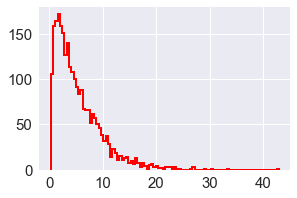

In [133]:
# Calculating number of pits at each bin of the PMF of actual depth of truly detected pits at t_3
(estimated_N_WO_POD_3, bins_3, patches3) = plt.hist(D_3['depth'], bins_no, \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_3.actual_N = actual_N_3
frequency_info_3.estimated_N_WO_POD = estimated_N_WO_POD_3

In [134]:
# Estimate the number of actual pits (M_3) given the number of truly detected pits (m_3) at ILI_3:
for i in range (1, bins_no+1):
    POD = 1-np.exp(-(bins_3[i-1]+bins_3[i])/2/detection_threshold)
    frequency_info_3.estimated_N_W_POD[i] = frequency_info_3.estimated_N_WO_POD[i]/POD
frequency_info_3.rounded_estimated_N_W_POD = np.round(frequency_info_3.estimated_N_W_POD, 0)

In [135]:
frequency_info_3.head()

,actual_N,detected_N,reported_N,estimated_N_WO_POD,estimated_N_W_POD,rounded_estimated_N_W_POD
1,544.0,61.0,531.616958,105.0,229.245862,229.0
2,214.0,86.0,280.821076,158.0,234.586284,235.0
3,215.0,132.0,289.270984,164.0,204.147718,204.0
4,186.0,130.0,226.508563,171.0,193.979473,194.0
5,166.0,166.0,249.212491,158.0,170.141204,170.0


In [136]:
# Estimated number of existing pits at t_3
M_3 = np.int(np.sum(frequency_info_3.rounded_estimated_N_W_POD))
M_3

2870

In [137]:
np.random.seed(seed_number)
X_3 = pd.DataFrame(0, index = range(0, M_3), columns = range(1)).astype(float) 
for i in range(0, No_TrueCalled_Pits[2][1]): # change this to m_2
    X_3[0][i] = D_3['depth'][i]
# estimate the actual depth of undetected pits and find the distribution of X_3

jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_3.rounded_estimated_N_W_POD[i] > frequency_info_3.estimated_N_WO_POD[i]:        
        for j in range(1, np.int(frequency_info_3.rounded_estimated_N_W_POD[i] - frequency_info_3.estimated_N_WO_POD[i])+1):          
            X = np.random.uniform(bins_3[i-1], bins_3[i])
            X_3[0][No_TrueCalled_Pits[2][1] + jj] = X # change this to m_3
            jj = jj + 1     
X_3.to_csv('X_3.csv')

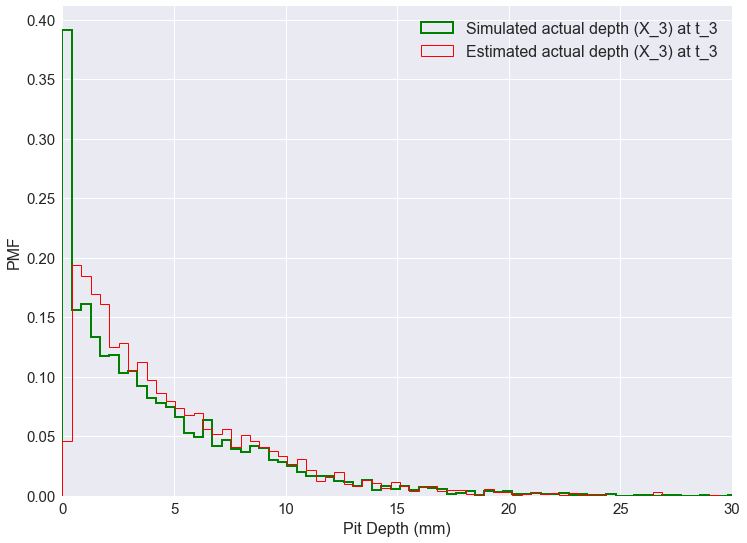

In [138]:
# Visual comparison between actual and estimated depth for X_3
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth (mm)', fontsize = 16)
plt.ylabel('PMF', fontsize = 16)
bins_start_X_3 = np.int(np.min([np.min(pd.concat([Initiation_3_Actual_Depth[0], Initiation_2_Actual_Depth[1],\
                                                Initiation_1_Actual_Depth[2]])), np.min(X_3[0])]))
bins_end_X_3   = np.int(np.max([np.max(pd.concat([Initiation_3_Actual_Depth[0], Initiation_2_Actual_Depth[1],\
                                                Initiation_1_Actual_Depth[2]])), np.max(X_3[0])]))
plt.hist(pd.concat([Initiation_3_Actual_Depth[0], Initiation_2_Actual_Depth[1], Initiation_1_Actual_Depth[2]]),\
         bins_no, color = 'green', range=(bins_start_X_3, bins_end_X_3), histtype='step', normed=True, linewidth=2,\
         label='Simulated actual depth (X_3) at t_3');
plt.hist(X_3[0], bins_no, color = 'red', range=(bins_start_X_3, bins_end_X_3), histtype='step', normed=True, linewidth=1,\
         label='Estimated actual depth (X_3) at t_3');

plt.xlim([bins_start_X_3, 30]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

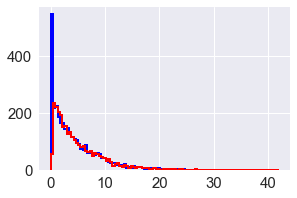

In [139]:
(actual_N_3, bins_3, patches) = plt.hist(pd.concat([Initiation_3_Actual_Depth[0], Initiation_2_Actual_Depth[1],\
                                                    Initiation_1_Actual_Depth[2]]), bins_no, \
                                         range=(bins_start_X_3, bins_end_X_3), histtype='step', normed=False, linewidth=2,\
                                         color = 'blue', label='Distribution of actual samples ILI_3');
(estimated_N_W_POD_3, bins_3, patches3) = plt.hist(X_3[0], bins_no, range=(bins_start_X_3, bins_end_X_3),\
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');


In [140]:
N_Actual_3 = pd.concat([Initiation_3_Actual_Depth[0],\
                Initiation_2_Actual_Depth[1], Initiation_1_Actual_Depth[2]]).shape[0]
N_Estimated_3 = X_3.shape[0] 
KLD3 = KL_divergences(actual_N_3/N_Actual_3, estimated_N_WO_POD_3/N_Estimated_3, bins_no)
KLD3

0.23310169399884986

In [141]:
SKLD3 = (KL_divergences(actual_N_3/N_Actual_3, estimated_N_WO_POD_3/N_Estimated_3, bins_no) + \
         KL_divergences(estimated_N_WO_POD_3/N_Estimated_3, actual_N_3/N_Actual_3, bins_no))/2
SKLD3

0.11195242890806487

In [142]:
ChiSq_3 = 0
for i in range(0, bins_no):
    if actual_N_3[i] > 0 or estimated_N_W_POD_3[i] > 0:
        ChiSq_3 = ChiSq_3 + (actual_N_3[i]/N_Actual_3 - estimated_N_W_POD_3[i]/N_Estimated_3)**2/\
        (actual_N_3[i]/N_Actual_3 + estimated_N_W_POD_3[i]/N_Estimated_3)
ChiSq_3

0.14280342204144922

# X_3_c

1678
1789


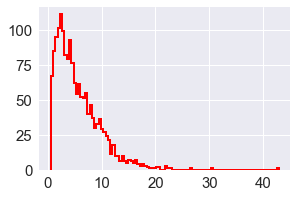

In [143]:
np.random.seed(seed_number)
# Calculating number of pits at each bin of the PMF of actual depth and estimated depth without POD: ILI_2_1
frequency_info_3_1 = pd.DataFrame(0, index = range(1, bins_no+1), columns = range(3)).astype(float)
frequency_info_3_1.columns = ['estimated_N_WO_POD', 'estimated_N_W_POD', 'rounded_estimated_N_W_POD']

(estimated_N_WO_POD_3_1, bins_3_1, patches_3_1) = plt.hist(D_3_1['depth'], bins_no, \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_3_1.estimated_N_WO_POD = estimated_N_WO_POD_3_1
# Estimate the number of actual pits (M_3_1) given the number of truly detected pits (m_3_1) at ILI_3:
for i in range (1, bins_no+1):
    POD = 1-np.exp(-(bins_3_1[i-1]+bins_3_1[i])/2/detection_threshold)
    frequency_info_3_1.estimated_N_W_POD[i] = frequency_info_3_1.estimated_N_WO_POD[i]/POD
frequency_info_3_1.rounded_estimated_N_W_POD = np.round(frequency_info_3_1.estimated_N_W_POD, 0)
m_prime_3_1 = np.int(np.sum(frequency_info_3_1.estimated_N_WO_POD))# The number of 
print(m_prime_3_1)
M_3_1 = np.int(np.sum(frequency_info_3_1.rounded_estimated_N_W_POD))
print(M_3_1)

# estimate the actual depth of undetected pits and find the distribution of X_3_1
X_3_1 = pd.DataFrame(0, index = range(0, M_3_1), columns = range(1)).astype(float) 
for i in range(0, m_prime_3_1): 
    X_3_1[0][i] = D_3_1['depth'][i]

jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_3_1.rounded_estimated_N_W_POD[i] > frequency_info_3_1.estimated_N_WO_POD[i]:        
        for j in range(1, np.int(frequency_info_3_1.rounded_estimated_N_W_POD[i] - frequency_info_3_1.estimated_N_WO_POD[i])\
                       +1):          
            X = np.random.uniform(bins_3_1[i-1], bins_3_1[i])
            X_3_1[0][m_prime_3_1 + jj] = X 
            jj = jj + 1     
X_3_1.to_csv('X_3_1.csv')

370
527


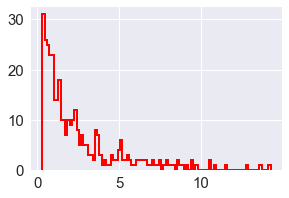

In [144]:
np.random.seed(seed_number)
# Calculating number of pits at each bin of the PMF of actual depth and estimated depth without POD: ILI_2_1
frequency_info_3_2 = pd.DataFrame(0, index = range(1, bins_no+1), columns = range(3)).astype(float)
frequency_info_3_2.columns = ['estimated_N_WO_POD', 'estimated_N_W_POD', 'rounded_estimated_N_W_POD']

(estimated_N_WO_POD_3_2, bins_3_2, patches_3_2) = plt.hist(D_3_2['depth'], bins_no, \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_3_2.estimated_N_WO_POD = estimated_N_WO_POD_3_2
# Estimate the number of actual pits (M_3_2) given the number of truly detected pits (m_3_2) at ILI_3:
for i in range (1, bins_no+1):
    POD = 1-np.exp(-(bins_3_2[i-1]+bins_3_2[i])/2/detection_threshold)
    frequency_info_3_2.estimated_N_W_POD[i] = frequency_info_3_2.estimated_N_WO_POD[i]/POD
frequency_info_3_2.rounded_estimated_N_W_POD = np.round(frequency_info_3_2.estimated_N_W_POD, 0)
m_prime_3_2 = np.int(np.sum(frequency_info_3_2.estimated_N_WO_POD))# The number of 
print(m_prime_3_2)
M_3_2 = np.int(np.sum(frequency_info_3_2.rounded_estimated_N_W_POD))
print(M_3_2)

# estimate the actual depth of undetected pits and find the distribution of X_3_2
X_3_2 = pd.DataFrame(0, index = range(0, M_3_2), columns = range(1)).astype(float) 
for i in range(0, m_prime_3_2): 
    X_3_2[0][i] = D_3_2['depth'][i]

jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_3_2.rounded_estimated_N_W_POD[i] > frequency_info_3_2.estimated_N_WO_POD[i]:        
        for j in range(1, np.int(frequency_info_3_2.rounded_estimated_N_W_POD[i] - frequency_info_3_2.estimated_N_WO_POD[i])\
                       +1):          
            X = np.random.uniform(bins_3_2[i-1], bins_3_2[i])
            X_3_2[0][m_prime_3_2 + jj] = X 
            jj = jj + 1     
X_3_2.to_csv('X_3_2.csv')

2210
2493


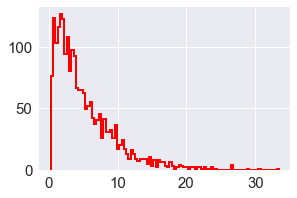

In [145]:
np.random.seed(seed_number)
# Calculating number of pits at each bin of the PMF of actual depth and estimated depth without POD: ILI_3_3
frequency_info_3_3 = pd.DataFrame(0, index = range(1, bins_no+1), columns = range(3)).astype(float)
frequency_info_3_3.columns = ['estimated_N_WO_POD', 'estimated_N_W_POD', 'rounded_estimated_N_W_POD']

(estimated_N_WO_POD_3_3, bins_3_3, patches_3_3) = plt.hist(D_3_3['depth'], bins_no, \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');
frequency_info_3_3.estimated_N_WO_POD = estimated_N_WO_POD_3_3
# Estimate the number of actual pits (M_3_3) given the number of truly detected pits (m_3_3) at ILI_3:
for i in range (1, bins_no+1):
    POD = 1-np.exp(-(bins_3_3[i-1]+bins_3_3[i])/2/detection_threshold)
    frequency_info_3_3.estimated_N_W_POD[i] = frequency_info_3_3.estimated_N_WO_POD[i]/POD
frequency_info_3_3.rounded_estimated_N_W_POD = np.round(frequency_info_3_3.estimated_N_W_POD, 0)
m_prime_3_3 = np.int(np.sum(frequency_info_3_3.estimated_N_WO_POD))# The number of 
print(m_prime_3_3)
M_3_3 = np.int(np.sum(frequency_info_3_3.rounded_estimated_N_W_POD))
print(M_3_3)

# estimate the actual depth of undetected pits and find the distribution of X_3_3
X_3_3 = pd.DataFrame(0, index = range(0, M_3_3), columns = range(1)).astype(float) 
for i in range(0, m_prime_3_3): 
    X_3_3[0][i] = D_3_3['depth'][i]

jj = 0
for i in range(1, bins_no+1):      
    if frequency_info_3_3.rounded_estimated_N_W_POD[i] > frequency_info_3_3.estimated_N_WO_POD[i]:        
        for j in range(1, np.int(frequency_info_3_3.rounded_estimated_N_W_POD[i] - frequency_info_3_3.estimated_N_WO_POD[i])\
                       +1):          
            X = np.random.uniform(bins_3_3[i-1], bins_3_3[i])
            X_3_3[0][m_prime_3_3 + jj] = X 
            jj = jj + 1     
X_3_3.to_csv('X_3_3.csv')

# 6- Prediction step at time t_4

# 6-1- Predict the number of new pits after ILI_3 and before t_4

# 6-2- USe MLE to estimate the rate of HPP

In [146]:
HPP_rate = (M_1_1+M_2 - M_1_1+M_3 - M_2)/(ILI_info.ILI_time[2])
HPP_rate

68.33333333333333

In [147]:
M_4_4 = np.int((ILI_info.ILI_time[3]-ILI_info.ILI_time[2])*HPP_rate) # this is the mean value of numbers
M_4_4

546

In [148]:
alpha_actual_4_1 = k_3 * (ILI_info.ILI_time[3] - 0) ** nu_3
alpha_actual_4_2 = k_3 * (ILI_info.ILI_time[3] - ILI_info.ILI_time[0]) ** nu_3
alpha_actual_4_3 = k_3 * (ILI_info.ILI_time[3] - ILI_info.ILI_time[1]) ** nu_3
alpha_actual_4_4 = k_3 * (ILI_info.ILI_time[3] - ILI_info.ILI_time[2]) ** nu_3


In [149]:
np.random.seed(seed_number)
X_4_1 = pd.DataFrame(0, index = range(1, M_1_1+1), columns = range(1)).astype(float)
X_4_1[0] = np.random.gamma(alpha_actual_4_1, scale=ScalePar_3, size=M_1_1) 
X_4_2 = pd.DataFrame(0, index = range(1, M_2 - M_1_1+1), columns = range(1)).astype(float)
X_4_2[0] = np.random.gamma(alpha_actual_4_2, scale=ScalePar_3, size=M_2 - M_1_1)
X_4_3 = pd.DataFrame(0, index = range(1, M_3 - M_2+1), columns = range(1)).astype(float)
X_4_3[0] = np.random.gamma(alpha_actual_4_3, scale=ScalePar_3, size= M_3 - M_2) 
X_4_4 = pd.DataFrame(0, index = range(1, M_4_4+1), columns = range(1)).astype(float)
X_4_4[0] = np.random.gamma(alpha_actual_4_4, scale=ScalePar_3, size=M_4_4) 
X_4 = pd.concat([X_4_1, X_4_2, X_4_3, X_4_4], axis=0, ignore_index=False)
X_4.to_csv('X_4.csv')

In [150]:
np.random.seed(seed_number)
X_4_1 = pd.DataFrame(0, index = range(1, M_1_1+1), columns = range(1)).astype(float)
for i in range (1, M_1_1+1):
    X_4_1[0][i] = np.random.gamma(k_3 * (ILI_info.ILI_time[3] - np.random.uniform(0, ILI_info.ILI_time[0]))\
                                  ** nu_3, scale=ScalePar_3) 

X_4_2 = pd.DataFrame(0, index = range(1, M_2 - M_1_1+1), columns = range(1)).astype(float)
for i in range (1, M_2 - M_1_1+1):
    X_4_2[0][i] = np.random.gamma(k_3 * (ILI_info.ILI_time[3] - np.random.uniform(ILI_info.ILI_time[0],\
                                   ILI_info.ILI_time[1])) ** nu_3, scale=ScalePar_3) 

X_4_3 = pd.DataFrame(0, index = range(1, M_3 - M_2+1), columns = range(1)).astype(float)
for i in range (1, M_3 - M_2+1):
    X_4_3[0][i] = np.random.gamma(k_3 * (ILI_info.ILI_time[3] - np.random.uniform(ILI_info.ILI_time[1],\
                                   ILI_info.ILI_time[2])) ** nu_3, scale=ScalePar_3) 

X_4_4 = pd.DataFrame(0, index = range(1, M_4_4+1), columns = range(1)).astype(float)
for i in range (1, M_4_4+1):
    X_4_4[0][i] = np.random.gamma(k_3 * (ILI_info.ILI_time[3] - np.random.uniform(ILI_info.ILI_time[2],\
                                   ILI_info.ILI_time[3])) ** nu_3, scale=ScalePar_3) 


X_4 = pd.concat([X_4_1, X_4_2, X_4_3, X_4_4], axis=0, ignore_index=False)
X_4.to_csv('X_4.csv')

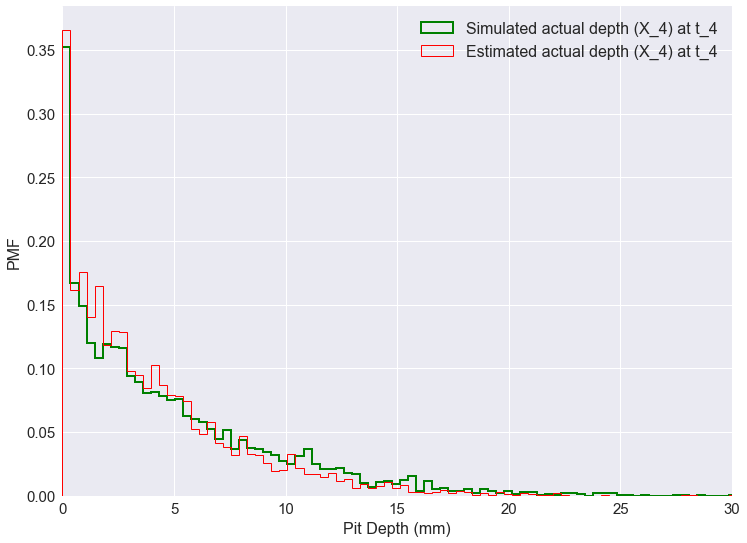

In [151]:
# Visual comparison between actual and estimated depth for X_4
plt.figure(figsize=(12, 9))
plt.xlabel('Pit Depth (mm)', fontsize = 16)
plt.ylabel('PMF', fontsize = 16)
bins_start_X_4 = np.int(np.min([np.min(pd.concat([Prediction_Actual_Depth[0], Initiation_3_Actual_Depth[1],\
                                                Initiation_2_Actual_Depth[2], Initiation_1_Actual_Depth[3]])),\
                              np.min(X_4[0])]))
bins_end_X_4   = np.int(np.max([np.max(pd.concat([Prediction_Actual_Depth[0], Initiation_3_Actual_Depth[1],\
                                                Initiation_2_Actual_Depth[2], Initiation_1_Actual_Depth[3]])),\
                              np.max(X_4[0])]))
plt.hist(pd.concat([Prediction_Actual_Depth[0], Initiation_3_Actual_Depth[1], Initiation_2_Actual_Depth[2],\
                    Initiation_1_Actual_Depth[3]]), bins_no, color = 'green', range=(bins_start_X_4, bins_end_X_4),\
         histtype='step', normed=True, linewidth=2, label='Simulated actual depth (X_4) at t_4');
plt.hist(X_4[0], bins_no, color = 'red', range=(bins_start_X_4, bins_end_X_4), histtype='step', normed=True,\
         linewidth=1, label='Estimated actual depth (X_4) at t_4');

plt.xlim([bins_start_X_4, 30]);
plt.title('' , fontsize = 16)
plt.legend(loc='upper right');

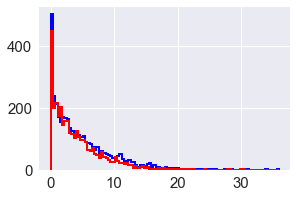

In [152]:
# Calculating number of pits at each bin of the PMF of actual depth and estimated depth without POD
(actual_N_4, bins_4, patches) = plt.hist(pd.concat([Prediction_Actual_Depth[0], Initiation_3_Actual_Depth[1],\
                                                    Initiation_2_Actual_Depth[2], Initiation_1_Actual_Depth[3]]),\
                                         bins_no, range=(bins_start_X_4, bins_end_X_4), histtype='step', normed=False,\
                                         linewidth=2, color = 'blue', label='Distribution of actual samples ILI_3');
(estimated_N_WO_POD_4, bins_4, patches4) = plt.hist(X_4[0], bins_no,range=(bins_start_X_4, bins_end_X_4), \
                                                 histtype='step', normed=False, linewidth=2, color = 'red',\
                                                 label='Distribution of estimated depth of detected pits');


In [153]:
N_Actual_4 = pd.concat([Prediction_Actual_Depth[0], Initiation_3_Actual_Depth[1],\
                Initiation_2_Actual_Depth[2], Initiation_1_Actual_Depth[3]]).shape[0]
N_Estimated_4 = X_4.shape[0] 
KLD4 = KL_divergences(actual_N_4/N_Actual_4, estimated_N_WO_POD_4/N_Estimated_4, bins_no)
KLD4

0.027572148773946443

In [154]:
SKLD4 = (KL_divergences(actual_N_4/N_Actual_4, estimated_N_WO_POD_4/N_Estimated_4, bins_no) + \
         KL_divergences(estimated_N_WO_POD_4/N_Estimated_4, actual_N_4/N_Actual_4, bins_no))/2
SKLD4

0.030026656831124904

In [1]:
ChiSq_4 = 0
for i in range(0, bins_no):
    if actual_N_4[i] > 0 or estimated_N_WO_POD_4[i] > 0:
        ChiSq_4 = ChiSq_4 + (actual_N_4[i]/N_Actual_4 - estimated_N_WO_POD_4[i]/N_Estimated_4)**2\
        /(actual_N_4[i]/N_Actual_4 + estimated_N_WO_POD_4[i]/N_Estimated_4)
ChiSq_4

NameError: name 'bins_no' is not defined

In [156]:
Results = pd.DataFrame(0, index = range(1, 10), columns = range(4)).astype(float)
Results.columns = ['assumed', 'ILI_1', 'ILI_2', 'ILI_3']
Results.index = ['k', 'nu', 'ScalePar', 'OB: alpha_1_1', 'OB: alpha_2_1', 'OB: alpha_2_2', 'OB: alpha_3_1',\
                 'OB: alpha_3_2', 'OB: alpha_3_3']
Results.assumed[0] = k
Results.assumed[1] = nu
Results.assumed[2] = ScalePar
Results.assumed[3] = alpha_1_1_actual
Results.assumed[4] = alpha_2_1_actual
Results.assumed[5] = alpha_2_2_actual
Results.assumed[6] = alpha_3_1_actual
Results.assumed[7] = alpha_3_2_actual
Results.assumed[8] = alpha_3_3_actual
Results.ILI_1[0] = k_1
Results.ILI_1[1] = nu_1
Results.ILI_1[2] = ScalePar_1
Results.ILI_1[3] = alpha_1_1_Est
Results.ILI_2[0] = k_2
Results.ILI_2[1] = nu_2
Results.ILI_2[2] = ScalePar_2
Results.ILI_2[4] = alpha_2_1_Est
Results.ILI_2[5] = alpha_2_2_Est 
Results.ILI_3[0] = k_3
Results.ILI_3[1] = nu_3
Results.ILI_3[2] = ScalePar_3
Results.ILI_3[6] = alpha_3_1_Est
Results.ILI_3[7] = alpha_3_2_Est
Results.ILI_3[8] = alpha_3_3_Est

Results

,assumed,ILI_1,ILI_2,ILI_3
k,0.120000,0.510200,0.1293,0.1608
nu,0.771000,0.374000,0.7229,0.6705
ScalePar,3.500000,3.073000,3.0260,3.1740
OB: alpha_1_1,1.652121,1.820471,0.0000,0.0000
OB: alpha_2_1,1.942070,0.000000,1.7520,0.0000
OB: alpha_2_2,0.537962,0.000000,0.5262,0.0000
OB: alpha_3_1,2.141443,0.000000,0.0000,1.9700
OB: alpha_3_2,0.815136,0.000000,0.0000,0.8500
OB: alpha_3_3,0.415037,0.000000,0.0000,0.4700


In [157]:
ILI_info.Estimated_Pit_No[0] = M_1_1
ILI_info.Estimated_Pit_No[1] = M_2 - M_1_1
ILI_info.Estimated_Pit_No[2] = M_3 - M_2
ILI_info.Estimated_Pit_No[3] = M_4_4
ILI_info.KLD[0] = np.round(KLD1,2)
ILI_info.KLD[1] = KLD2
ILI_info.KLD[2] = KLD3
ILI_info.KLD[3] = KLD4
ILI_info.ChiSq[0] = ChiSq_1
ILI_info.ChiSq[1] = ChiSq_2
ILI_info.ChiSq[2] = ChiSq_3
ILI_info.ChiSq[3] = ChiSq_4
ILI_info

,ILI_time,Actual_Pit_No,Estimated_Pit_No,KLD,ChiSq
ILI_1,30,2374,1816.0,0.350000,0.276937
ILI_2,37,577,725.0,0.333704,0.119331
ILI_3,42,381,329.0,0.233102,0.142803
Prediction Time,50,631,546.0,0.027572,0.033701


In [158]:
Pit_generation_rate

80

In [159]:
HPP_rate

68.33333333333333

In [160]:
def PosNormal(mean, sigma):
    x = np.random.normal(mean,sigma)
    return(x if x>=0 else PosNormal(mean,sigma))

In [161]:
def CumulativeHist (bins_No, Freqs):
    CH = np.zeros (bins_No)
    for i in range(1, bins_No):
        CH[i] = CH[i-1] + Freqs[i-1]
    return(CH)

In [162]:
def DiscMCS(CumulHist, bins, bins_no):
    rand = np.random.uniform(0,1)*CumulHist[bins_no-1]
    for i in range(1, bins_no):
        if rand > CumulHist[i-1] and rand < CumulHist[i]:
            sample = ((bins[i]-bins[i-1])*rand-bins[i]*CumulHist[i-1]+bins[i-1]*CumulHist[i])/\
            (CumulHist[i] - CumulHist[i-1])
    return(sample)   

In [163]:
CumuHist_X_4 = CumulativeHist(bins_no, estimated_N_WO_POD_4)

In [164]:
np.random.seed(seed_number)
MCSIterNo = 10000
Operating_pressure_mean = 6.66       # MPa
Operating_pressure_STD  = Operating_pressure_mean * 0.02 # MPa
# Calculating probability of small leak at each time
prob_of_failure = pd.DataFrame(0, index=range(1, 1), columns=range(4)).astype(float)
prob_of_failure.columns = ["Safe", "Small Leak", "Large Leak", "Rupture"]
OperPressSamples = pd.DataFrame(0, index=range(0, MCSIterNo), columns=range(1)).astype(float)
BurstPressSamples = pd.DataFrame(0, index=range(1), columns=range(1)).astype(float)
RupturePressSamples = pd.DataFrame(0, index=range(1), columns=range(1)).astype(float)
PWTSamples = pd.DataFrame(0, index=range(0, MCSIterNo), columns=range(1)).astype(float)
X_4_sample = np.zeros(MCSIterNo)
for i in range(0, MCSIterNo):
    X_4_sample[i] = DiscMCS(CumuHist_X_4, bins_4, bins_no)

## Samplin from a histogram X_4
# Cumalative histogram CX_4
pit_length_mean = 15 # mm
pit_length_STD  = 3 # mm
small_leak_threshold = 0.8 * PWT # 0.8 is the common value in the literature
ultimate_tensile_strength_mean = 456  # MPa
ultimate_tensile_strength_STD = ultimate_tensile_strength_mean * 0.03  # MPa
epsilon = 1
outer_diameter = 506  # mm

N_small   = 0
N_large   = 0
N_rupture = 0
Counter = 0
for k in range(0, MCSIterNo):       
    pit_length = PosNormal(pit_length_mean, pit_length_STD)
    UTS = PosNormal(ultimate_tensile_strength_mean, ultimate_tensile_strength_STD)
    Op_pressure = PosNormal(Operating_pressure_mean, Operating_pressure_STD)
    PWTSample1 = PosNormal(Operating_pressure_mean, Operating_pressure_STD)
    PWTSample = PWT
    OperPressSamples.loc[k,0] = Op_pressure    
    PWTSamples.loc[k,0] = PWTSample1
    f1 = small_leak_threshold - X_4_sample[k]
    if f1 <= 0 :#and f2 > 0:
        N_small  = N_small + 1
    else:
        # burst pressure
        Pb = epsilon * UTS * PWTSample / outer_diameter * (1 - X_4_sample[k]/ PWTSample *\
            (1- np.exp(-0.157 * pit_length / np.sqrt(outer_diameter*(PWTSample - X_4_sample[k]) / 2))))
        if pit_length**2 / (outer_diameter * PWTSample) <= 50:
            M = np.sqrt(1+0.6275 * pit_length**2/(outer_diameter * PWTSample)-0.003375*pit_length**4 \
                        / (outer_diameter * PWTSample)**2)
        else:
            M =  3.3 + 0.032 * pit_length**2/(outer_diameter * PWTSample) 
        P_rupture = 2 * PWTSample * 0.9 * UTS / (M * outer_diameter)        
        BurstPressSamples.loc[Counter,0] = Pb
        RupturePressSamples.loc[Counter,0] = P_rupture
        Counter = Counter + 1        
        f2 = Pb - Op_pressure
        f3 = P_rupture - Op_pressure

        if f2 <= 0 and f3 > 0:
            N_large  = N_large + 1
        if f2 <= 0 and f3 <= 0:
            N_rupture  = N_rupture + 1 
prob_of_failure.loc[1, 'Small Leak'] = N_small / MCSIterNo
prob_of_failure.loc[1, 'Large Leak'] = N_large / MCSIterNo
prob_of_failure.loc[1, 'Rupture']    = N_rupture / MCSIterNo
prob_of_failure.loc[1, 'Safe'] = (MCSIterNo - N_small - N_large - N_rupture) / MCSIterNo

In [165]:
prob_of_failure

,Safe,Small Leak,Large Leak,Rupture
1,0.8033,0.19,0.0067,0.0


In [171]:
# Some characteristics for plots
plt.rc('legend',**{'fontsize':20})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 

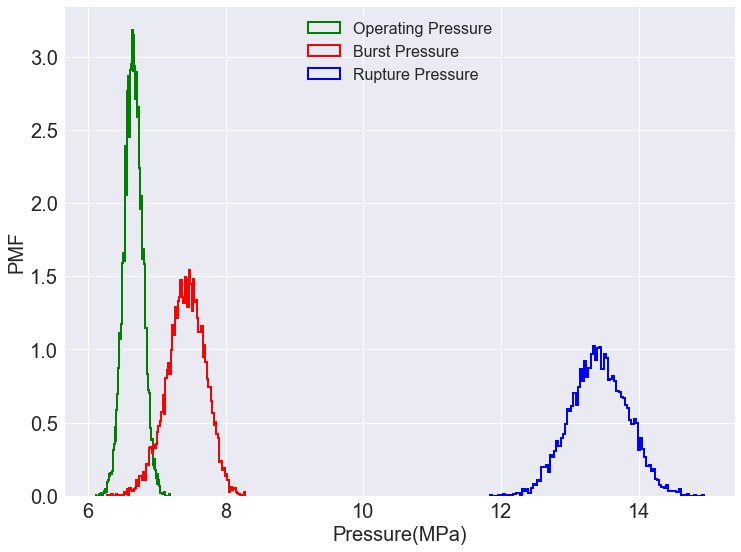

In [177]:
plt.figure(figsize=(12, 9))
plt.xlabel('Pressure(MPa)', fontsize = 20)
plt.ylabel('PMF', fontsize = 20)
# bins_start_X_1 = np.int(np.min([np.min(Initiation_1_Actual_Depth[0]), np.min(X_1[0])]))
# bins_end_X_1   = np.int(np.max([np.max(Initiation_1_Actual_Depth[0]), np.max(X_1[0])]))
plt.hist(OperPressSamples[0], 100, color = 'green', \
         histtype='step', density=True,  linewidth=2, label='Operating Pressure');
plt.hist(BurstPressSamples[0], 100, color = 'red', \
          histtype='step', density=True, linewidth=2, label='Burst Pressure');

plt.hist(RupturePressSamples[0], 100, color = 'blue', \
          histtype='step', density=True, linewidth=2, label='Rupture Pressure');

plt.title('' , fontsize = 20)
plt.legend(loc='upper center', fontsize = 16)
plt.colors = 'red'